# Parallel KMeans implementation
Based on J. Y. Q. H. Z. W. a. J. C. Bowen Wang, “Parallelizing K-means-based Clustering on Spark,” International Conference on Advanced Cloud and Big Data, 2016. 

## Parallel partition based algorithm outline
1. Initialize centroids by randomly selecting k points from the data set. Broadcast selected centroids to all nodes
1. While centrodis still changing:
    1. For each partition do locally:
        1. For each point in partition:
            1. Compute distance to all centroids
            1. Asign closest cluster
        1. For each cluster in partition:
            1. Compute local mean
    1. Compute mean for each cluster for each partition
 

## Adaptations made to sugested implementation of the algorithm:
1. The authors suggest using SparseVector, with chosen data sets it is better to use regular arrys
1. We use random sample for centroids initialization as described in *Scalable K-Means++* because quality of inital centrods has a major effect on quality
1. We use crisp clustring only i. e. each point can be a member of one cluster only
1. We use euclidian data because it is the recommended distance function for dense data.

## Description of production cluster on Azure:
We are using Azure HDIsight in order to run a spark cluster. We are using a cluster with the following configuration:
* two master nodes Standard_D12_V2 4 CPU Cores 28GB RAM
* eight slave nodes Standard_D13_V2 8 CPU Cores 56GB RAM

In [1]:
import random 
import time
import math
import logging
import itertools
import typing
from numpy import array
import numpy as np
import pandas as pd
from scipy import spatial
import matplotlib.pyplot as plt
from pprint import pprint
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.mllib.clustering import KMeans, KMeansModel
from itertools import groupby, compress

from typing import Tuple, Sequence

sc.stop()
conf = SparkConf().set("spark.python.profile", "true")
conf.set("spark.driver.memory", "13G")
sc = SparkContext(conf=conf)

sc.setLogLevel('ERROR')
# For reproducability of results
RANDOM_SEED = 301191

%matplotlib inline

sc.getConf().getAll()


log4jLogger = sc._jvm.org.apache.log4j 
log = log4jLogger.LogManager.getLogger(__name__) 

In [2]:
dict(logging.Logger.manager.loggerDict.items())

{'concurrent.futures': <Logger concurrent.futures (WARNING)>,
 'concurrent': <logging.PlaceHolder at 0x7fe83a70a640>,
 'asyncio': <Logger asyncio (WARNING)>,
 'tornado.access': <Logger tornado.access (WARNING)>,
 'tornado': <Logger tornado (WARNING)>,
 'tornado.application': <Logger tornado.application (WARNING)>,
 'tornado.general': <Logger tornado.general (WARNING)>,
 'prompt_toolkit.buffer': <Logger prompt_toolkit.buffer (WARNING)>,
 'prompt_toolkit': <logging.PlaceHolder at 0x7fe837673910>,
 'parso.python.diff': <Logger parso.python.diff (WARNING)>,
 'parso.python': <logging.PlaceHolder at 0x7fe83714e7c0>,
 'parso': <logging.PlaceHolder at 0x7fe83714e820>,
 'parso.cache': <Logger parso.cache (WARNING)>,
 'IPKernelApp': <Logger IPKernelApp (WARNING)>,
 'py4j': <Logger py4j (WARNING)>,
 'py4j.java_gateway': <Logger py4j.java_gateway (WARNING)>,
 'py4j.clientserver': <Logger py4j.clientserver (WARNING)>,
 'PIL.Image': <Logger PIL.Image (WARNING)>,
 'PIL': <logging.PlaceHolder at 0x7fe

### Import test data and parse data set

In [3]:
data = sc.textFile("data/a3.txt")
parsed_data = data.map(lambda line: array([float(x) for x in line.strip().split()]))
parsed_data.cache()

parsed_data.take(5)

[array([53920., 42968.]),
 array([52019., 42206.]),
 array([52570., 42476.]),
 array([54220., 42081.]),
 array([54268., 43420.])]

In [4]:
parsed_data.count()

7500

In [5]:
def euclidean_dist(v1, v2):
    return np.linalg.norm(v1-v2)
    
def closest_centroid(point, centroids):
    # for dense data, we use euclidean distance
    centroid_dist_pairs = map(lambda centroid: (centroid, euclidean_dist(point, centroid)), centroids)
    return min(centroid_dist_pairs, key=lambda centroid_dist: centroid_dist[1])

def clac_mean_points_in_cluster_pandas(distances):
    # not in use. slower implementation of means calculation
    df = pd.DataFrame(distances, columns=['Point', 'Centroid', 'Distance'])
    df['Centroid'] = tuple(df['Centroid'])

    return df.groupby('Centroid')['Point'].apply(np.mean).items()

def clac_mean_points_in_cluster(distances):
    def keyfunc(item):
        return tuple(item[1])
    
    sorted_distances = sorted(distances, key=keyfunc)
    for k, g in groupby(sorted_distances, keyfunc):
        yield k, np.mean(array(list(g), dtype='object')[:,0], axis=0)

def calc_partition_centroid_means(partition, centroids):
    distances = map(lambda point: (point, 
                                   *closest_centroid(point, centroids)), 
                    partition)
    
    group = clac_mean_points_in_cluster(distances)
    return group

def closest_centroids_per_partition(data, centroids):
    """
    calculate local means for each centroid on each partition to avoid transfer of large volume of data
    
    @param data: rdd, the actual data set
    @param centroids:
    @return: rdd of tuples (original centroid, mean of points close to this centroid on each partition)
    """
    result = data.mapPartitions(lambda partition: calc_partition_centroid_means(partition, centroids.value))
    return result

def color_hash(point):
    hsh = int(point[0] ** 2 + point[1] ** 2)
    return '#' + str(hex(hsh % int('ffffff', 16)))[2:].zfill(6)

def calc_error(new_centroids_series: pd.DataFrame):
    old_and_new_centroids = array(list(new_centroids_series.items()))
    error = np.linalg.norm((old_and_new_centroids[:,0] - old_and_new_centroids[:,1]))
    return error

def aggregate_means(closest_centroids):
    df = pd.DataFrame(closest_centroids, columns=['Centroid', 'Point']) 
    new_centroids_series = df.groupby('Centroid')['Point'].apply(np.mean)
    return new_centroids_series

def pkmeans(data, n, max_iterations=150, stop_distance=0.01):
    init_centroids = array(data.takeSample(False, n, seed=RANDOM_SEED))
    centroids = sc.broadcast(init_centroids)
    
    iteration = 1
    error = True
    while error > stop_distance and iteration <= max_iterations:
        loop_start = time.time()
        closest_centroids_rdd = closest_centroids_per_partition(data, centroids)
        closest_centroids = closest_centroids_rdd.collect()
        new_centroids_series = aggregate_means(closest_centroids)
        error = calc_error(new_centroids_series)
        print("Iteration #{0}\tDistance between old and new centroids: {1:.4f}\tIteration took: {2:.4f} sec".format(
                                                                iteration, error, time.time() - loop_start))
        centroids = sc.broadcast(new_centroids_series.to_list())
        iteration += 1
    
    return new_centroids_series.to_list()
    

In [6]:
final_centroids = pkmeans(parsed_data, 50)

Iteration #1	Distance between old and new centroids: 17177.0580	Iteration took: 1.4168 sec


Iteration #2	Distance between old and new centroids: 10533.1843	Iteration took: 1.3703 sec


Iteration #3	Distance between old and new centroids: 8960.0502	Iteration took: 1.3766 sec


Iteration #4	Distance between old and new centroids: 5625.2528	Iteration took: 1.3319 sec


Iteration #5	Distance between old and new centroids: 2716.5609	Iteration took: 1.3169 sec


Iteration #6	Distance between old and new centroids: 1167.5255	Iteration took: 1.3207 sec


Iteration #7	Distance between old and new centroids: 652.2470	Iteration took: 1.3062 sec


Iteration #8	Distance between old and new centroids: 426.8672	Iteration took: 1.4220 sec


Iteration #9	Distance between old and new centroids: 475.1348	Iteration took: 1.4535 sec


Iteration #10	Distance between old and new centroids: 436.4036	Iteration took: 1.3231 sec


Iteration #11	Distance between old and new centroids: 332.5501	Iteration took: 1.3204 sec


Iteration #12	Distance between old and new centroids: 266.5829	Iteration took: 1.3308 sec


Iteration #13	Distance between old and new centroids: 269.6818	Iteration took: 1.3068 sec


Iteration #14	Distance between old and new centroids: 224.8819	Iteration took: 1.3705 sec


Iteration #15	Distance between old and new centroids: 102.3555	Iteration took: 1.3022 sec


Iteration #16	Distance between old and new centroids: 112.5089	Iteration took: 1.3757 sec


Iteration #17	Distance between old and new centroids: 75.1935	Iteration took: 1.3180 sec


Iteration #18	Distance between old and new centroids: 48.4089	Iteration took: 1.3000 sec


Iteration #19	Distance between old and new centroids: 0.0000	Iteration took: 1.3136 sec


### Run profiler to see what slows down

In [7]:
%load_ext line_profiler

In [8]:
def test_porfile():
    pkmeans(parsed_data, 50)

In [9]:
%lprun -f pkmeans test_porfile()

Iteration #1	Distance between old and new centroids: 17177.0580	Iteration took: 1.3528 sec


Iteration #2	Distance between old and new centroids: 10533.1843	Iteration took: 1.3258 sec


Iteration #3	Distance between old and new centroids: 8960.0502	Iteration took: 1.3273 sec


Iteration #4	Distance between old and new centroids: 5625.2528	Iteration took: 1.3487 sec


Iteration #5	Distance between old and new centroids: 2716.5609	Iteration took: 1.3178 sec


Iteration #6	Distance between old and new centroids: 1167.5255	Iteration took: 1.3089 sec


Iteration #7	Distance between old and new centroids: 652.2470	Iteration took: 1.3243 sec


Iteration #8	Distance between old and new centroids: 426.8672	Iteration took: 1.3692 sec


Iteration #9	Distance between old and new centroids: 475.1348	Iteration took: 1.3122 sec


Iteration #10	Distance between old and new centroids: 436.4036	Iteration took: 1.3332 sec


Iteration #11	Distance between old and new centroids: 332.5501	Iteration took: 1.3217 sec


Iteration #12	Distance between old and new centroids: 266.5829	Iteration took: 1.3122 sec


Iteration #13	Distance between old and new centroids: 269.6818	Iteration took: 1.3456 sec


Iteration #14	Distance between old and new centroids: 224.8819	Iteration took: 1.3128 sec


Iteration #15	Distance between old and new centroids: 102.3555	Iteration took: 1.3731 sec


Iteration #16	Distance between old and new centroids: 112.5089	Iteration took: 1.3320 sec


Iteration #17	Distance between old and new centroids: 75.1935	Iteration took: 1.3023 sec


Iteration #18	Distance between old and new centroids: 48.4089	Iteration took: 1.3405 sec


Iteration #19	Distance between old and new centroids: 0.0000	Iteration took: 1.3096 sec


```
Timer unit: 1e-06 s

Total time: 27.4172 s
File: <ipython-input-150-1dd397ddc730>
Function: pkmeans at line 56

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    56                                           def pkmeans(data, n, max_iterations=150, stop_distance=0.01):
    57         1     101992.0 101992.0      0.4      init_centroids = array(data.takeSample(False, n, seed=RANDOM_SEED))
    58         1       2476.0   2476.0      0.0      centroids = sc.broadcast(init_centroids)
    59                                               
    60         1          1.0      1.0      0.0      iteration = 1
    61         1          0.0      0.0      0.0      error = True
    62        20         47.0      2.4      0.0      while error > stop_distance and iteration <= max_iterations:
    63        19         27.0      1.4      0.0          loop_start = time.time()
    64        19        435.0     22.9      0.0          closest_centroids_rdd = closest_centroids_per_partition(data, centroids)
    65        19   26590086.0 1399478.2     97.0          closest_centroids = closest_centroids_rdd.collect()
    66        19     648951.0  34155.3      2.4          new_centroids_series = aggregate_means(closest_centroids)
    67        19       3301.0    173.7      0.0          error = calc_error(new_centroids_series)
    68        19         34.0      1.8      0.0          print("Iteration #{0}\tDistance between old and new centroid: {1:.4f}\tIteration took: {2:.4f} sec".format(
    69        19       3429.0    180.5      0.0                                                                  iteration, error, time.time() - loop_start))
    70        19      66310.0   3490.0      0.2          centroids = sc.broadcast(new_centroids_series.to_list())
    71        19         32.0      1.7      0.0          iteration += 1
    72                                               
    73         1         33.0     33.0      0.0      return new_centroids_series.to_list()
 ```

__We can see that most time is spent on computation of closest_centroids_rdd.__ <br>
__Now, we will turn on the spark profiler to see what takes the most time__

In [10]:
sc.show_profiles()

Profile of RDD<id=2>
         97740 function calls in 0.063 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       24    0.020    0.001    0.020    0.001 {built-in method _pickle.dumps}
     7500    0.008    0.000    0.008    0.000 {built-in method numpy.array}
     7500    0.005    0.000    0.020    0.000 3982770169.py:2(<lambda>)
        2    0.005    0.003    0.063    0.032 serializers.py:255(dump_stream)
     7500    0.005    0.000    0.005    0.000 3982770169.py:2(<listcomp>)
     7502    0.004    0.000    0.012    0.000 serializers.py:524(loads)
     7502    0.004    0.000    0.006    0.000 serializers.py:561(read_int)
     7500    0.004    0.000    0.023    0.000 util.py:71(wrapper)
     7502    0.002    0.000    0.014    0.000 serializers.py:533(load_stream)
    15002    0.002    0.000    0.002    0.000 {method 'read' of '_io.BufferedReader' objects}
     7502    0.001    0.000    0.001    0.000 {bu

       55    0.000    0.000    0.000    0.000 fromnumeric.py:3317(_mean_dispatcher)
      110    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
       10    0.000    0.000    0.000    0.000 serializers.py:568(write_int)
       55    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.normalize_axis_index}
        2    0.000    0.000    0.000    0.000 broadcast.py:117(load_from_path)
        2    0.000    0.000    2.606    1.303 worker.py:592(process)
       10    0.000    0.000    0.001    0.000 serializers.py:426(dumps)
        2    0.000    0.000    0.000    0.000 broadcast.py:121(load)
        2    0.000    0.000    0.000    0.000 {method '__exit__' of '_io._IOBase' objects}
       44    0.000    0.000    0.000    0.000 {built-in method builtins.len}
       10    0.000    0.000    0.000    0.000 {built-in method _struct.pack}
       55    0.000    0.000    0.000    0.000 {built-in method numpy.asanyarray}
        2    0.000    0.000

Profile of RDD<id=20>
         5686487 function calls (5311487 primitive calls) in 2.630 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   375000    0.824    0.000    1.518    0.000 linalg.py:2363(norm)
750055/375055    0.485    0.000    1.705    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   375000    0.374    0.000    2.266    0.000 3107262757.py:1(euclidean_dist)
     7500    0.171    0.000    2.585    0.000 {built-in method builtins.min}
   375000    0.154    0.000    1.892    0.000 <__array_function__ internals>:2(norm)
   375000    0.130    0.000    0.466    0.000 <__array_function__ internals>:2(dot)
   375000    0.102    0.000    2.368    0.000 3107262757.py:6(<lambda>)
   375000    0.067    0.000    0.067    0.000 {method 'ravel' of 'numpy.ndarray' objects}
   750110    0.063    0.000    0.063    0.000 {built-in method builtins.issubclass}
   375000    0.056    0.

       55    0.000    0.000    0.003    0.000 <__array_function__ internals>:2(mean)
       26    0.000    0.000    0.000    0.000 serializers.py:561(read_int)
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
        2    0.000    0.000    0.000    0.000 broadcast.py:117(load_from_path)
       26    0.000    0.000    0.010    0.000 serializers.py:135(load_stream)
       26    0.000    0.000    0.000    0.000 {built-in method _struct.unpack}
       24    0.000    0.000    0.010    0.000 serializers.py:429(loads)
      110    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
       10    0.000    0.000    0.000    0.000 serializers.py:568(write_int)
       55    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.normalize_axis_index}
       10    0.000    0.000    0.001    0.000 serializers.py:426(dumps)
        2    0.000    0.000    2.535    1.268 worker.py:592(process)
        2    0.000    0.000    0.000    0.000

       20    0.000    0.000    0.000    0.000 {method 'write' of '_io.BufferedWriter' objects}
        2    0.000    0.000    0.000    0.000 broadcast.py:129(value)
        2    0.000    0.000    0.000    0.000 serializers.py:213(load_stream)
        2    0.000    0.000    0.000    0.000 3107262757.py:40(<lambda>)
       10    0.000    0.000    0.000    0.000 __init__.py:145(_DType_reduce)
        2    0.000    0.000    0.000    0.000 3107262757.py:24(calc_partition_centroid_means)
        4    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
        2    0.000    0.000    0.000    0.000 serializers.py:216(_load_stream_without_unbatching)
        2    0.000    0.000    0.000    0.000 rdd.py:417(func)
        2    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        2    0.000    0.000    0.000    0.000 {method 'close' of 'generator' objects}
        2    0.000    0.000    0.000    0.000 {built-in method from_iterable}
        2   

        2    0.000    0.000    0.000    0.000 {built-in method gc.disable}


Profile of RDD<id=34>
         5686487 function calls (5311487 primitive calls) in 2.547 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   375000    0.799    0.000    1.466    0.000 linalg.py:2363(norm)
750055/375055    0.466    0.000    1.648    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   375000    0.362    0.000    2.194    0.000 3107262757.py:1(euclidean_dist)
     7500    0.166    0.000    2.502    0.000 {built-in method builtins.min}
   375000    0.153    0.000    1.832    0.000 <__array_function__ internals>:2(norm)
   375000    0.125    0.000    0.445    0.000 <__array_function__ internals>:2(dot)
   375000    0.097    0.000    2.291    0.000 3107262757.py:6(<lambda>)
   375000    0.065    0.000    0.065    0.000 {method 'ravel' of 'numpy.ndarray' objects}
   750110    0.061    0.000    

   375000    0.041    0.000    0.041    0.000 {built-in method numpy.asarray}
   375000    0.036    0.000    0.036    0.000 linalg.py:2359(_norm_dispatcher)
   375000    0.034    0.000    0.034    0.000 multiarray.py:736(dot)
    15000    0.010    0.000    0.010    0.000 3107262757.py:17(keyfunc)
     7500    0.006    0.000    2.509    0.000 3107262757.py:25(<lambda>)
     7500    0.005    0.000    2.503    0.000 3107262757.py:4(closest_centroid)
        2    0.004    0.002    2.529    1.264 {built-in method builtins.sorted}
       55    0.003    0.000    0.003    0.000 {built-in method numpy.array}
     7600    0.003    0.000    0.003    0.000 {method 'reshape' of 'numpy.ndarray' objects}
     7600    0.003    0.000    0.003    0.000 {built-in method numpy.frombuffer}
       24    0.003    0.000    0.010    0.000 {built-in method _pickle.loads}
       55    0.002    0.000    0.002    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     7600    0.002    0.000    0.008    0.000 numeric

       26    0.000    0.000    0.011    0.000 serializers.py:135(load_stream)
       24    0.000    0.000    0.011    0.000 serializers.py:429(loads)
      110    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
       10    0.000    0.000    0.000    0.000 serializers.py:568(write_int)
       55    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.normalize_axis_index}
       10    0.000    0.000    0.001    0.000 serializers.py:426(dumps)
        2    0.000    0.000    2.635    1.318 worker.py:592(process)
        2    0.000    0.000    0.000    0.000 broadcast.py:117(load_from_path)
       10    0.000    0.000    0.000    0.000 {built-in method _struct.pack}
        2    0.000    0.000    0.000    0.000 broadcast.py:121(load)
       44    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        2    0.000    0.000    0.000    0.000 {method '__exit__' of '_io._IOBase' objects}
       55    0.000    0.000    0.000    0.

```
============================================================
Profile of RDD<id=7>
============================================================
         6135955 function calls (5760955 primitive calls) in 4.590 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   375000    1.419    0.000    2.767    0.000 linalg.py:2316(norm)
750055/375055    0.679    0.000    3.022    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   375000    0.619    0.000    3.914    0.000 <ipython-input-3-fc001fb89f2d>:1(euclidean_dist)
     7500    0.304    0.000    4.418    0.001 {built-in method builtins.min}
   375000    0.239    0.000    0.239    0.000 {method 'ravel' of 'numpy.ndarray' objects}
   375000    0.228    0.000    3.295    0.000 <__array_function__ internals>:2(norm)
   375000    0.215    0.000    0.700    0.000 <__array_function__ internals>:2(dot)
   382610    0.146    0.000    0.146    0.000 {built-in method numpy.array}
   375000    0.143    0.000    4.056    0.000 <ipython-input-3-fc001fb89f2d>:6(<lambda>)
   375000    0.101    0.000    0.219    0.000 _asarray.py:16(asarray)
   750110    0.099    0.000    0.099    0.000 {built-in method builtins.issubclass}
   375000    0.091    0.000    0.138    0.000 linalg.py:121(isComplexType)
   375000    0.058    0.000    0.058    0.000 <ipython-input-3-fc001fb89f2d>:7(<lambda>)
   375000    0.054    0.000    0.054    0.000 multiarray.py:707(dot)
   375000    0.051    0.000    0.051    0.000 linalg.py:2312(_norm_dispatcher)
        2    0.016    0.008    4.567    2.284 {built-in method builtins.sorted}
     7500    0.014    0.000    0.055    0.000 <ipython-input-2-1ef6232a3f15>:2(<lambda>)
     7502    0.014    0.000    0.039    0.000 serializers.py:684(loads)
    15000    0.013    0.000    0.013    0.000 <ipython-input-3-fc001fb89f2d>:17(keyfunc)
     7500    0.011    0.000    4.438    0.001 <ipython-input-3-fc001fb89f2d>:25(<lambda>)
     7500    0.010    0.000    0.010    0.000 <ipython-input-2-1ef6232a3f15>:2(<listcomp>)
     7500    0.009    0.000    4.427    0.001 <ipython-input-3-fc001fb89f2d>:4(closest_centroid)
     7502    0.009    0.000    0.018    0.000 serializers.py:721(read_int)
     7502    0.007    0.000    0.045    0.000 serializers.py:693(load_stream)
    15002    0.006    0.000    0.006    0.000 {method 'read' of '_io.BufferedReader' objects}
     7500    0.006    0.000    0.061    0.000 util.py:97(wrapper)
       55    0.006    0.000    0.006    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     7500    0.005    0.000    0.005    0.000 {method 'decode' of 'bytes' objects}
     7502    0.005    0.000    0.005    0.000 {built-in method _struct.unpack}
     7500    0.004    0.000    0.004    0.000 {method 'split' of 'str' objects}
       57    0.004    0.000    4.587    0.080 <ipython-input-3-fc001fb89f2d>:16(clac_mean_points_in_cluster)
     7500    0.002    0.000    0.002    0.000 {method 'strip' of 'str' objects}
        2    0.001    0.001    4.589    2.295 serializers.py:396(dump_stream)
       10    0.001    0.000    0.001    0.000 {built-in method _pickle.dumps}
       55    0.001    0.000    0.006    0.000 _methods.py:134(_mean)
        2    0.000    0.000    0.000    0.000 {built-in method _pickle.load}
       55    0.000    0.000    0.006    0.000 fromnumeric.py:3231(mean)
       55    0.000    0.000    0.000    0.000 _methods.py:50(_count_reduce_items)
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
       55    0.000    0.000    0.007    0.000 <__array_function__ internals>:2(mean)
      110    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        2    0.000    0.000    0.001    0.000 broadcast.py:123(load_from_path)
        2    0.000    0.000    4.590    2.295 worker.py:370(process)
       55    0.000    0.000    0.000    0.000 _asarray.py:88(asanyarray)
       10    0.000    0.000    0.000    0.000 serializers.py:728(write_int)
       10    0.000    0.000    0.001    0.000 serializers.py:582(dumps)
        2    0.000    0.000    0.001    0.000 broadcast.py:135(value)
        2    0.000    0.000    0.000    0.000 broadcast.py:127(load)
       20    0.000    0.000    0.000    0.000 {method 'write' of '_io.BufferedWriter' objects}
       55    0.000    0.000    0.000    0.000 fromnumeric.py:3227(_mean_dispatcher)
        2    0.000    0.000    0.001    0.000 <ipython-input-3-fc001fb89f2d>:40(<lambda>)
       10    0.000    0.000    0.000    0.000 {built-in method _struct.pack}
        2    0.000    0.000    0.001    0.000 rdd.py:2498(pipeline_func)
        2    0.000    0.000    0.000    0.000 rdd.py:323(func)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
        2    0.000    0.000    0.001    0.000 rdd.py:351(func)
       20    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        2    0.000    0.000    0.000    0.000 <ipython-input-3-fc001fb89f2d>:24(calc_partition_centroid_means)
        2    0.000    0.000    0.000    0.000 util.py:92(fail_on_stopiteration)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
        2    0.000    0.000    0.000    0.000 {built-in method gc.enable}
        2    0.000    0.000    0.000    0.000 {built-in method gc.disable}
        2    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

```

__We can see that most of the time is spent on calculation in numpy, python is a slower language__


__Most of the time is taken by p.linalg.norm__

__We will try to change the euqlidian distnce funution to use scipy module__

In [11]:
from scipy.spatial import distance

def euclidean_dist(v1, v2):
    return distance.euclidean(v1, v2)

pkmeans(parsed_data, 50)
sc.show_profiles()

Iteration #1	Distance between old and new centroids: 17177.0580	Iteration took: 1.7400 sec


Iteration #2	Distance between old and new centroids: 10533.1843	Iteration took: 1.6937 sec


Iteration #3	Distance between old and new centroids: 8960.0502	Iteration took: 1.6580 sec


Iteration #4	Distance between old and new centroids: 5625.2528	Iteration took: 1.6483 sec


Iteration #5	Distance between old and new centroids: 2716.5609	Iteration took: 1.6281 sec


Iteration #6	Distance between old and new centroids: 1167.5255	Iteration took: 1.7457 sec


Iteration #7	Distance between old and new centroids: 652.2470	Iteration took: 1.6352 sec


Iteration #8	Distance between old and new centroids: 426.8672	Iteration took: 1.6107 sec


Iteration #9	Distance between old and new centroids: 475.1348	Iteration took: 1.6624 sec


Iteration #10	Distance between old and new centroids: 436.4036	Iteration took: 1.6449 sec


Iteration #11	Distance between old and new centroids: 332.5501	Iteration took: 1.6086 sec


Iteration #12	Distance between old and new centroids: 266.5829	Iteration took: 1.6145 sec


Iteration #13	Distance between old and new centroids: 269.6818	Iteration took: 1.6193 sec


Iteration #14	Distance between old and new centroids: 224.8819	Iteration took: 1.6392 sec


Iteration #15	Distance between old and new centroids: 102.3555	Iteration took: 1.6101 sec


Iteration #16	Distance between old and new centroids: 112.5089	Iteration took: 1.6366 sec


Iteration #17	Distance between old and new centroids: 75.1935	Iteration took: 1.6530 sec


Iteration #18	Distance between old and new centroids: 48.4089	Iteration took: 1.6352 sec


Iteration #19	Distance between old and new centroids: 0.0000	Iteration took: 1.6234 sec
Profile of RDD<id=47>
         30288 function calls (30286 primitive calls) in 0.025 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       50    0.006    0.000    0.006    0.000 {method 'read' of '_io.BufferedReader' objects}
     7500    0.005    0.000    0.005    0.000 {built-in method numpy.frombuffer}
       24    0.004    0.000    0.016    0.001 {built-in method _pickle.loads}
     7500    0.003    0.000    0.003    0.000 {method 'reshape' of 'numpy.ndarray' objects}
     7500    0.003    0.000    0.012    0.000 numeric.py:1854(_frombuffer)
     7502    0.002    0.000    0.024    0.000 rdd.py:1235(<genexpr>)
        2    0.001    0.000    0.001    0.000 {built-in method _pickle.dumps}
        4    0.000    0.000    0.024    0.006 {built-in method builtins.sum}
       26    0.000    0.000    0.022    0.001 serialize

   375055    0.525    0.000    0.525    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   375000    0.469    0.000    2.668    0.000 distance.py:436(minkowski)
   375000    0.429    0.000    1.923    0.000 misc.py:17(norm)
   750000    0.172    0.000    0.276    0.000 distance.py:298(_validate_vector)
  1125000    0.144    0.000    0.144    0.000 {built-in method numpy.asarray}
     7500    0.144    0.000    3.166    0.000 {built-in method builtins.min}
   375000    0.136    0.000    0.191    0.000 blas.py:383(getter)
   375000    0.131    0.000    0.737    0.000 {method 'all' of 'numpy.ndarray' objects}
   375000    0.118    0.000    2.892    0.000 1186506596.py:3(euclidean_dist)
   375000    0.106    0.000    2.773    0.000 distance.py:561(euclidean)
   375000    0.086    0.000    2.978    0.000 3107262757.py:6(<lambda>)
   375000    0.082    0.000    0.605    0.000 _methods.py:60(_all)
   375000    0.054    0.000    0.054    0.000 {method 'get' of 'dict' objects}
   375000    0.04

        2    0.004    0.002    3.141    1.571 {built-in method builtins.sorted}
       55    0.003    0.000    0.003    0.000 {built-in method numpy.array}
     7600    0.003    0.000    0.003    0.000 {method 'reshape' of 'numpy.ndarray' objects}
     7600    0.003    0.000    0.003    0.000 {built-in method numpy.frombuffer}
       24    0.002    0.000    0.010    0.000 {built-in method _pickle.loads}
     7600    0.002    0.000    0.008    0.000 numeric.py:1854(_frombuffer)
       57    0.002    0.000    3.154    0.055 3107262757.py:16(clac_mean_points_in_cluster)
        2    0.001    0.000    3.155    1.578 serializers.py:255(dump_stream)
       10    0.000    0.000    0.000    0.000 {built-in method _pickle.dumps}
       55    0.000    0.000    0.003    0.000 _methods.py:162(_mean)
       55    0.000    0.000    0.000    0.000 _methods.py:66(_count_reduce_items)
       50    0.000    0.000    0.000    0.000 {method 'read' of '_io.BufferedReader' objects}
       26    0.000    0.0

        2    0.000    0.000    0.000    0.000 {built-in method io.open}
       26    0.000    0.000    0.010    0.000 serializers.py:135(load_stream)
       26    0.000    0.000    0.000    0.000 {built-in method _struct.unpack}
       24    0.000    0.000    0.010    0.000 serializers.py:429(loads)
      110    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
       10    0.000    0.000    0.000    0.000 serializers.py:568(write_int)
      110    0.000    0.000    0.000    0.000 {built-in method builtins.issubclass}
       55    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.normalize_axis_index}
       10    0.000    0.000    0.000    0.000 serializers.py:426(dumps)
        2    0.000    0.000    3.128    1.564 worker.py:592(process)
        2    0.000    0.000    0.000    0.000 {method '__exit__' of '_io._IOBase' objects}
        2    0.000    0.000    0.000    0.000 broadcast.py:117(load_from_path)
       44    0.000    0.000   

       55    0.000    0.000    0.003    0.000 _methods.py:162(_mean)
       55    0.000    0.000    0.000    0.000 _methods.py:66(_count_reduce_items)
        2    0.000    0.000    0.000    0.000 {built-in method _pickle.load}
       50    0.000    0.000    0.000    0.000 {method 'read' of '_io.BufferedReader' objects}
       26    0.000    0.000    0.011    0.000 serializers.py:151(_read_with_length)
       55    0.000    0.000    0.003    0.000 fromnumeric.py:3322(mean)
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
       26    0.000    0.000    0.000    0.000 serializers.py:561(read_int)
       55    0.000    0.000    0.003    0.000 <__array_function__ internals>:2(mean)
       55    0.000    0.000    0.003    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       26    0.000    0.000    0.000    0.000 {built-in method _struct.unpack}
       24    0.000    0.000    0.010    0.000 serializers.py:429(loads)
       26    0.000   

```
============================================================
Profile of RDD<id=76>
============================================================
         97562104 function calls (96062104 primitive calls) in 86.889 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   750000   11.313    0.000   33.786    0.000 arrayprint.py:863(fillFormat)
  1500000   10.916    0.000   75.867    0.000 {built-in method builtins.print}
  1875055    5.186    0.000    5.186    0.000 {method 'reduce' of 'numpy.ufunc' objects}
2250000/750000    5.138    0.000   13.491    0.000 arrayprint.py:718(recurser)
  2999800    4.278    0.000    4.278    0.000 {built-in method numpy.core._multiarray_umath.dragon4_positional}
  1500000    3.971    0.000    6.233    0.000 arrayprint.py:947(__call__)
   750000    2.623    0.000   57.050    0.000 arrayprint.py:478(_array2string)
  2249850    2.198    0.000    4.214    0.000 arrayprint.py:913(<genexpr>)
   750000    2.107    0.000   39.790    0.000 arrayprint.py:409(_get_format_function)
  1500000    1.912    0.000    4.518    0.000 _ufunc_config.py:32(seterr)
   750000    1.815    0.000   64.082    0.000 arrayprint.py:516(array2string)
  1500000    1.668    0.000    6.021    0.000 fromnumeric.py:70(_wrapreduction)
   750000    1.559    0.000   35.645    0.000 arrayprint.py:836(__init__)
  1500000    1.495    0.000    1.629    0.000 _ufunc_config.py:132(geterr)
   750000    1.474    0.000   59.129    0.000 arrayprint.py:461(wrapper)
   750000    1.342    0.000    2.672    0.000 arrayprint.py:60(_make_options_dict)
 18000146    1.264    0.000    1.264    0.000 {built-in method builtins.len}
  2250055    1.233    0.000    9.821    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   375000    1.233    0.000    9.323    0.000 distance.py:454(minkowski)
  1500000    1.113    0.000    1.433    0.000 arrayprint.py:695(_extendLine)
  2250050    1.091    0.000    2.017    0.000 {built-in method builtins.max}
   375000    1.082    0.000    4.315    0.000 misc.py:17(norm)
  2249850    1.067    0.000    5.594    0.000 arrayprint.py:918(<genexpr>)
   750000    1.023    0.000    1.023    0.000 arrayprint.py:358(_get_formatdict)
   750000    0.983    0.000    3.775    0.000 distance.py:326(_validate_vector)
   375000    0.928    0.000    2.842    0.000 function_base.py:422(asarray_chkfinite)
   750000    0.873    0.000    0.873    0.000 {built-in method builtins.locals}
   750000    0.869    0.000   64.951    0.000 arrayprint.py:1473(_array_str_implementation)
   375000    0.843    0.000   86.276    0.000 <ipython-input-39-e8707e66c8fb>:3(euclidean_dist)
   750000    0.794    0.000    1.262    0.000 shape_base.py:24(atleast_1d)
   750000    0.775    0.000    4.710    0.000 fromnumeric.py:2589(amax)
   750000    0.726    0.000   36.372    0.000 arrayprint.py:366(<lambda>)
  2625110    0.725    0.000    0.725    0.000 {built-in method numpy.array}
  1500000    0.691    0.000    0.691    0.000 {built-in method numpy.seterrobj}
   750000    0.656    0.000   14.148    0.000 arrayprint.py:709(_formatArray)
   750000    0.526    0.000    2.613    0.000 fromnumeric.py:2714(amin)
   750000    0.488    0.000    5.774    0.000 <__array_function__ internals>:2(amax)
  1500000    0.486    0.000    0.486    0.000 fromnumeric.py:71(<dictcomp>)
   750000    0.481    0.000    3.417    0.000 _ufunc_config.py:433(__enter__)
   750000    0.457    0.000    2.039    0.000 _ufunc_config.py:438(__exit__)
  1875000    0.448    0.000    1.018    0.000 _asarray.py:14(asarray)
  3000000    0.421    0.000    0.421    0.000 {built-in method numpy.geterrobj}
   750000    0.402    0.000    2.149    0.000 <__array_function__ internals>:2(atleast_1d)
  2249850    0.389    0.000    0.520    0.000 arrayprint.py:922(<genexpr>)
   750000    0.373    0.000    0.373    0.000 arrayprint.py:65(<dictcomp>)
   750000    0.352    0.000    3.416    0.000 <__array_function__ internals>:2(amin)
     7500    0.332    0.000   86.822    0.012 {built-in method builtins.min}
  1500000    0.313    0.000    0.313    0.000 {method 'split' of 'str' objects}
  2249850    0.310    0.000    0.406    0.000 arrayprint.py:923(<genexpr>)
  3000110    0.288    0.000    0.288    0.000 {built-in method builtins.issubclass}
   750000    0.253    0.000    0.253    0.000 _ufunc_config.py:429(__init__)
   375000    0.244    0.000    9.567    0.000 distance.py:578(euclidean)
  2250000    0.239    0.000    0.239    0.000 {method 'items' of 'dict' objects}
   375000    0.237    0.000    0.391    0.000 blas.py:370(getter)
   750000    0.214    0.000    0.214    0.000 {method 'update' of 'dict' objects}
   375000    0.209    0.000    1.769    0.000 {method 'all' of 'numpy.ndarray' objects}
   750000    0.204    0.000    0.204    0.000 {method 'discard' of 'set' objects}
   750000    0.193    0.000    0.193    0.000 {method 'squeeze' of 'numpy.ndarray' objects}
   750000    0.184    0.000    0.184    0.000 {method 'copy' of 'dict' objects}
   750055    0.169    0.000    0.318    0.000 _asarray.py:86(asanyarray)
   750110    0.157    0.000    0.157    0.000 {built-in method builtins.isinstance}
   375000    0.154    0.000    0.154    0.000 {method 'get' of 'dict' objects}
   375000    0.144    0.000   86.420    0.000 <ipython-input-33-e15f9ffbec71>:6(<lambda>)
   750000    0.144    0.000    0.144    0.000 arrayprint.py:827(_none_or_positive_arg)
   750000    0.140    0.000    0.140    0.000 {built-in method builtins.id}
   750000    0.138    0.000    0.138    0.000 {method 'add' of 'set' objects}
   750000    0.133    0.000    0.133    0.000 {method 'rstrip' of 'str' objects}
   750000    0.124    0.000    0.124    0.000 {built-in method _thread.get_ident}
   750000    0.110    0.000    0.110    0.000 fromnumeric.py:2584(_amax_dispatcher)
   750000    0.091    0.000    0.091    0.000 fromnumeric.py:2709(_amin_dispatcher)
   375000    0.090    0.000    1.560    0.000 _methods.py:56(_all)
   750000    0.083    0.000    0.083    0.000 {method 'append' of 'list' objects}
   750000    0.080    0.000    0.080    0.000 shape_base.py:20(_atleast_1d_dispatcher)
   375000    0.070    0.000    0.070    0.000 <ipython-input-33-e15f9ffbec71>:7(<lambda>)
    15000    0.011    0.000    0.011    0.000 <ipython-input-33-e15f9ffbec71>:17(keyfunc)
     7500    0.011    0.000   86.843    0.012 <ipython-input-33-e15f9ffbec71>:25(<lambda>)
     7500    0.010    0.000   86.832    0.012 <ipython-input-33-e15f9ffbec71>:4(closest_centroid)
        2    0.010    0.005   86.869   43.435 {built-in method builtins.sorted}
     7600    0.003    0.000    0.003    0.000 {method 'reshape' of 'numpy.ndarray' objects}
       24    0.003    0.000    0.011    0.000 {built-in method _pickle.loads}
     7600    0.003    0.000    0.003    0.000 {built-in method numpy.frombuffer}
       57    0.002    0.000   86.886    1.524 <ipython-input-33-e15f9ffbec71>:16(clac_mean_points_in_cluster)
     7600    0.002    0.000    0.008    0.000 numeric.py:1812(_frombuffer)
        2    0.002    0.001   86.889   43.444 serializers.py:267(dump_stream)
       10    0.001    0.000    0.001    0.000 {built-in method _pickle.dumps}
      200    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.dragon4_scientific}
       55    0.000    0.000    0.004    0.000 _methods.py:143(_mean)
      150    0.000    0.000    0.000    0.000 arrayprint.py:888(<genexpr>)
      150    0.000    0.000    0.001    0.000 arrayprint.py:891(<genexpr>)
       50    0.000    0.000    0.000    0.000 {method 'read' of '_io.BufferedReader' objects}
       55    0.000    0.000    0.004    0.000 fromnumeric.py:3269(mean)
       26    0.000    0.000    0.011    0.000 serializers.py:163(_read_with_length)
        2    0.000    0.000    0.000    0.000 {built-in method _pickle.load}
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
        2    0.000    0.000    0.000    0.000 {method 'write' of '_io.TextIOWrapper' objects}
       55    0.000    0.000    0.000    0.000 _methods.py:59(_count_reduce_items)
      150    0.000    0.000    0.000    0.000 arrayprint.py:893(<genexpr>)
       26    0.000    0.000    0.000    0.000 serializers.py:592(read_int)
      150    0.000    0.000    0.000    0.000 arrayprint.py:896(<genexpr>)
       26    0.000    0.000    0.011    0.000 serializers.py:144(load_stream)
       55    0.000    0.000    0.004    0.000 <__array_function__ internals>:2(mean)
       26    0.000    0.000    0.000    0.000 {built-in method _struct.unpack}
       24    0.000    0.000    0.011    0.000 serializers.py:457(loads)
      150    0.000    0.000    0.000    0.000 arrayprint.py:892(<genexpr>)
      100    0.000    0.000    0.000    0.000 {method 'partition' of 'str' objects}
       10    0.000    0.000    0.000    0.000 serializers.py:599(write_int)
      150    0.000    0.000    0.000    0.000 arrayprint.py:903(<genexpr>)
       10    0.000    0.000    0.001    0.000 serializers.py:453(dumps)
        2    0.000    0.000    0.000    0.000 broadcast.py:121(load_from_path)
       55    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.normalize_axis_index}
       10    0.000    0.000    0.000    0.000 {built-in method _struct.pack}
        2    0.000    0.000    0.000    0.000 warnings.py:35(_formatwarnmsg_impl)
        2    0.000    0.000   86.889   43.444 worker.py:593(process)
       20    0.000    0.000    0.000    0.000 {method 'write' of '_io.BufferedWriter' objects}
        2    0.000    0.000    0.000    0.000 broadcast.py:125(load)
       55    0.000    0.000    0.000    0.000 fromnumeric.py:3265(_mean_dispatcher)
        2    0.000    0.000    0.000    0.000 broadcast.py:133(value)
        2    0.000    0.000    0.000    0.000 warnings.py:20(_showwarnmsg_impl)
        2    0.000    0.000    0.000    0.000 warnings.py:403(__init__)
        2    0.000    0.000    0.000    0.000 linecache.py:82(updatecache)
        2    0.000    0.000    0.000    0.000 serializers.py:225(load_stream)
        2    0.000    0.000    0.000    0.000 <ipython-input-33-e15f9ffbec71>:40(<lambda>)
        2    0.000    0.000    0.000    0.000 linecache.py:15(getline)
        2    0.000    0.000    0.000    0.000 linecache.py:37(getlines)
        2    0.000    0.000    0.000    0.000 warnings.py:96(_showwarnmsg)
        2    0.000    0.000    0.000    0.000 warnings.py:117(_formatwarnmsg)
        4    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
        2    0.000    0.000    0.000    0.000 <ipython-input-33-e15f9ffbec71>:24(calc_partition_centroid_means)
        2    0.000    0.000    0.000    0.000 serializers.py:228(_load_stream_without_unbatching)
        2    0.000    0.000    0.000    0.000 {method 'endswith' of 'str' objects}
        2    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        2    0.000    0.000    0.000    0.000 {method 'close' of 'generator' objects}
        2    0.000    0.000    0.000    0.000 rdd.py:424(func)
        2    0.000    0.000    0.000    0.000 {method 'startswith' of 'str' objects}
        2    0.000    0.000    0.000    0.000 {built-in method from_iterable}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
        2    0.000    0.000    0.000    0.000 {built-in method gc.disable}
        2    0.000    0.000    0.000    0.000 {built-in method gc.enable}
```

__We can see from the results that distance.euclidean(v1, v2) has even worst performance!__

__We will use a different aproach to imporve the performance: index the centroids in KDTree and search closes centroid using the the KDTree for each point.__

__The main change is inside the calc_partition_centroid_means function__

In [12]:
def calc_closest_centroid(points: itertools.chain, centroids) -> typing.Iterable[typing.Tuple[np.ndarray, np.ndarray]]:
    tree = spatial.KDTree(centroids)
    for point in points:
        yield point, centroids[tree.query(point)[1]]
        
def clac_mean_points_in_cluster(distances):
    def keyfunc(item):
        return tuple(item[1])
    
    sorted_distances = sorted(distances, key=keyfunc)
    for k, g in groupby(sorted_distances, keyfunc):
        yield k, np.mean(array(list(g))[:,0], axis=0)

def calc_partition_centroid_means(partition, centroids):
    point_centroid_pair = calc_closest_centroid(partition, centroids.value)
    group = clac_mean_points_in_cluster(point_centroid_pair)
    return group

def closest_centroids_per_partition(data, centroids):
    """
    calculate local means for each centroid on each partition to avoid transfer of large volume of data
    
    @param data: rdd, the actual data set
    @param centroids:
    @return: rdd of tuples (original centroid, mean of points close to this centroid on each partition)
    """
    result = data.mapPartitions(lambda partition: calc_partition_centroid_means(partition, centroids))
    return result

def color_hash(point):
    hsh = int(point[0] ** 2 + point[1] ** 2)
    return '#' + str(hex(hsh % int('ffffff', 16)))[2:].zfill(6)

def calc_error(new_centroids_series: pd.DataFrame):
    old_and_new_centroids = array(list(new_centroids_series.items()))
    error = np.linalg.norm((old_and_new_centroids[:,0] - old_and_new_centroids[:,1]))
    return error

def aggregate_means(closest_centroids):
    df = pd.DataFrame(closest_centroids, columns=['Centroid', 'Point']) 
    new_centroids_series = df.groupby('Centroid')['Point'].apply(np.mean)
    return new_centroids_series

def pkmeans(data, n, max_iterations=150, stop_distance=0.01):
    init_centroids = array(data.takeSample(False, n, seed=RANDOM_SEED))
    centroids = sc.broadcast(init_centroids)
    
    iteration = 1
    error = True
    while error > stop_distance and iteration <= max_iterations:
        loop_start = time.time()
        closest_centroids_rdd = closest_centroids_per_partition(data, centroids)
        closest_centroids = closest_centroids_rdd.collect()
        new_centroids_series = aggregate_means(closest_centroids)
        error = calc_error(new_centroids_series)
        print("Iteration #{0}\tDistance between old and new centroids: {1:.4f}\tIteration took: {2:.4f} sec".format(
                                                                iteration, error, time.time() - loop_start))
        centroids = sc.broadcast(new_centroids_series.to_list())
        iteration += 1
    
    return new_centroids_series.to_list()

final_centroids = pkmeans(parsed_data, 50)
sc.show_profiles()

Iteration #1	Distance between old and new centroids: 17177.0580	Iteration took: 0.2286 sec
Iteration #2	Distance between old and new centroids: 10533.1843	Iteration took: 0.2095 sec
Iteration #3	Distance between old and new centroids: 8960.0502	Iteration took: 0.1854 sec
Iteration #4	Distance between old and new centroids: 5625.2528	Iteration took: 0.1858 sec
Iteration #5	Distance between old and new centroids: 2716.5609	Iteration took: 0.2711 sec
Iteration #6	Distance between old and new centroids: 1167.5255	Iteration took: 0.1657 sec
Iteration #7	Distance between old and new centroids: 652.2470	Iteration took: 0.1851 sec
Iteration #8	Distance between old and new centroids: 426.8672	Iteration took: 0.1642 sec
Iteration #9	Distance between old and new centroids: 475.1348	Iteration took: 0.2745 sec
Iteration #10	Distance between old and new centroids: 436.4036	Iteration took: 0.3053 sec
Iteration #11	Distance between old and new centroids: 332.5501	Iteration took: 0.1754 sec
Iteration #

       55    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(mean)
        2    0.000    0.000    0.000    0.000 kdtree.py:336(__init__)
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
       26    0.000    0.000    0.000    0.000 serializers.py:561(read_int)
       26    0.000    0.000    0.012    0.000 serializers.py:135(load_stream)
       26    0.000    0.000    0.000    0.000 {built-in method _struct.unpack}
       24    0.000    0.000    0.012    0.000 serializers.py:429(loads)
       10    0.000    0.000    0.000    0.000 serializers.py:568(write_int)
       55    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.normalize_axis_index}
       10    0.000    0.000    0.001    0.000 serializers.py:426(dumps)
      110    0.000    0.000    0.000    0.000 {built-in method builtins.issubclass}
       10    0.000    0.000    0.000    0.000 {built-in method _struct.pack}
        2    0.000    0.000    0.292    0.146 

       55    0.000    0.000    0.001    0.000 fromnumeric.py:3322(mean)
       26    0.000    0.000    0.011    0.000 serializers.py:151(_read_with_length)
        2    0.000    0.000    0.000    0.000 kdtree.py:336(__init__)
       55    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(mean)
       26    0.000    0.000    0.000    0.000 serializers.py:561(read_int)
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
       26    0.000    0.000    0.011    0.000 serializers.py:135(load_stream)
       24    0.000    0.000    0.011    0.000 serializers.py:429(loads)
       26    0.000    0.000    0.000    0.000 {built-in method _struct.unpack}
       10    0.000    0.000    0.000    0.000 serializers.py:568(write_int)
       55    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.normalize_axis_index}
      110    0.000    0.000    0.000    0.000 {built-in method builtins.issubclass}
       10    0.000    0.000    0.002   

        2    0.000    0.000    0.000    0.000 fromnumeric.py:2763(amin)
        2    0.000    0.000    0.000    0.000 serializers.py:216(_load_stream_without_unbatching)
        2    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        2    0.000    0.000    0.000    0.000 3442377565.py:27(<lambda>)
        2    0.000    0.000    0.000    0.000 {method 'close' of 'generator' objects}
        2    0.000    0.000    0.000    0.000 rdd.py:417(func)
        4    0.000    0.000    0.000    0.000 function_base.py:722(_copy_dispatcher)
        2    0.000    0.000    0.000    0.000 {built-in method from_iterable}
        2    0.000    0.000    0.000    0.000 {built-in method gc.disable}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2758(_amin_dispatcher)
        2    0.000    0.000    0.000    0.000 {built-in method gc.enable}


Profile of RDD<id=79>
         331545

    15000    0.015    0.000    0.039    0.000 fromnumeric.py:38(_wrapit)
    22502    0.014    0.000    0.014    0.000 {built-in method numpy.asarray}
    22600    0.011    0.000    0.011    0.000 {method 'reshape' of 'numpy.ndarray' objects}
     7502    0.011    0.000    0.337    0.000 3442377565.py:1(calc_closest_centroid)
    15000    0.009    0.000    0.009    0.000 3442377565.py:7(keyfunc)
     7504    0.008    0.000    0.041    0.000 fromnumeric.py:69(_wrapreduction)
    15000    0.007    0.000    0.007    0.000 fromnumeric.py:193(_reshape_dispatcher)
    15000    0.006    0.000    0.111    0.000 <__array_function__ internals>:2(reshape)
     7502    0.006    0.000    0.047    0.000 fromnumeric.py:2638(amax)
    15000    0.006    0.000    0.070    0.000 fromnumeric.py:198(reshape)
       59    0.005    0.000    0.005    0.000 {built-in method numpy.array}
     7500    0.004    0.000    0.015    0.000 <__array_function__ internals>:2(shape)
     7502    0.003    0.000    0.057   

       55    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(mean)
        2    0.000    0.000    0.000    0.000 kdtree.py:336(__init__)
       26    0.000    0.000    0.010    0.000 serializers.py:151(_read_with_length)
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
       26    0.000    0.000    0.000    0.000 serializers.py:561(read_int)
       55    0.000    0.000    0.000    0.000 fromnumeric.py:3317(_mean_dispatcher)
       26    0.000    0.000    0.010    0.000 serializers.py:135(load_stream)
       26    0.000    0.000    0.000    0.000 {built-in method _struct.unpack}
       24    0.000    0.000    0.010    0.000 serializers.py:429(loads)
       10    0.000    0.000    0.000    0.000 serializers.py:568(write_int)
       55    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.normalize_axis_index}
      110    0.000    0.000    0.000    0.000 {built-in method builtins.issubclass}
       10    0.000    0.000

__The results show a good performance imporvement!__

## Cluster validity
***
We are looking for a “good” structure of found clusters. We will use two measures compactness and separation which are the most popular ones.

The Compactness measures how closely data points are grouped in a cluster. Grouped points in the cluster are supposed to be related to each other, by sharing a common feature which reﬂects a meaningful pattern in practice. Compactness is normally based on distances between in cluster points. The very popular way of calculating the compactness is through variance, i.e., average distance to the mean, to estimate how objects are bonded together with its mean as its center. A small variance indicates a high compactness.

The Separation measures how different the found clusters are from each other. A distinct cluster that is far from the others corresponds to a unique pattern. Like the compactness, the distances between objects are widely used to measure separation, e.g., pairwise distances between cluster centers, or pairwise minimum distances between objects in different clusters. Separation is an inter-cluster criterion in the sense of relation between clusters. 

$D$ - the whole data set<br>
$g$ - center of whole data set<br>
$P$ - number of dimentions<br>
$C_i$ - i-th cluster<br>
$n_i$ - number of datat points in $C_i$<br>
$c_i$ - center of cluster $C_i$<br>


### RMSSTD calculation


RMSSTD is a square root of the pooled sample variance of all the attributes, which measures only the compactness of found clusters. Since the objective of cluster analysis is to form homogeneous groups the RMSSTD of a cluster should be as small as possible.

$RMSSTD= \sqrt{\large{\frac{\sum_{i}\sum_{x \in C_i}\lVert x - c_i \rVert ^ 2}
{P\sum_{i}(n_i - 1)}}}$


### RS calculation


RS is the complement of the ratio of sum of squared distances between objects in different clusters to the total sum of squares. It is an intuitive and simple formulation of measuring the differences between clusters. THe values of RS are between 0 and 1. In case that the values of RS is zero indicates that no difference exist among groups. On the other hand, when RS equals 1 there is an indication of significant difference among groups.

$RS = \large\frac
{\sum_{x \in D} \lVert x-g \rVert ^2 - \sum_{i}\sum_{x \in C_i} \lVert x - c_i \rVert ^2 }
{\sum_{x \in D} \lVert x-g \rVert ^2}$



In [13]:
def calc_point_centroid_pairs(data, centroids) -> pyspark.rdd.RDD:
    return data.map(lambda point: (tuple(closest_centroid(point, centroids)[0]), point))

def sum_of_squares_(centroid_points):
    s = 0
    points_ct = 0
    
    dim = len(centroid_points[0])    # get dimention of the point
    
    for centroid, points in centroid_points:
        centroid_arr = array(centroid)
        for point in points:
            s += euclidean_dist(point, centroid_arr)
            points_ct += 1    # count actual number of points in all the clusters
        points_ct -= 1        # required by the formula, reduce count by one
        
    return math.sqrt(s / (dim * points_ct))

def sum_of_squares_rmsstd(centroid_points):
    s = 0
    points_ct = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
        points_ct += 1
    
    return s, points_ct - 1  

def sum_of_squares_rs(centroid_points):
    s = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
    
    return s

def rmsstd(data: pyspark.rdd.RDD, centroids):
    dim = len(data.first())
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    s, n = point_centroid_pairs.groupByKey().map(sum_of_squares_rmsstd).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    return math.sqrt(s / (dim * n))

def rs(data: pyspark.rdd.RDD, centroids):
    g = data.mean()    # calc center of data
    sum_of_squares_total = data.map(lambda point: euclidean_dist(point, g)).sum()
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    sum_of_squres_clusters = point_centroid_pairs.groupByKey().map(sum_of_squares_rs).sum()
    
    return (sum_of_squares_total - sum_of_squres_clusters) / sum_of_squares_total
    


### Now we will run mllib kmeans algorithm and compare it to our result
* The first test of the algorithm is a syntetic data test
* Yellow sqares represent the data.
* Read dots are centers of clusters compueted by our implementation
* Black dots are the centerts of cluster computed by spark mllib algorithm

In [14]:
mllib_clusters = KMeans.train(parsed_data, 50, maxIterations=150, initializationMode="random")

In [15]:
rmsstd_custom = rmsstd(parsed_data, final_centroids)
rmsstd_mllib = rmsstd(parsed_data, mllib_clusters.centers)
rs_custom = rs(parsed_data, final_centroids)
rs_mmlib = rs(parsed_data,  mllib_clusters.centers)

print(f"our algorithm\trmsstd: {rmsstd_custom}\trs: {rs_custom}")
print(f"mllib algorithm\trmsstd: {rmsstd_mllib}\trs: {rs_mmlib}")

our algorithm	rmsstd: 33.05817971660287	rs: 0.908514342499134
mllib algorithm	rmsstd: 35.57449021220725	rs: 0.8940569402661758


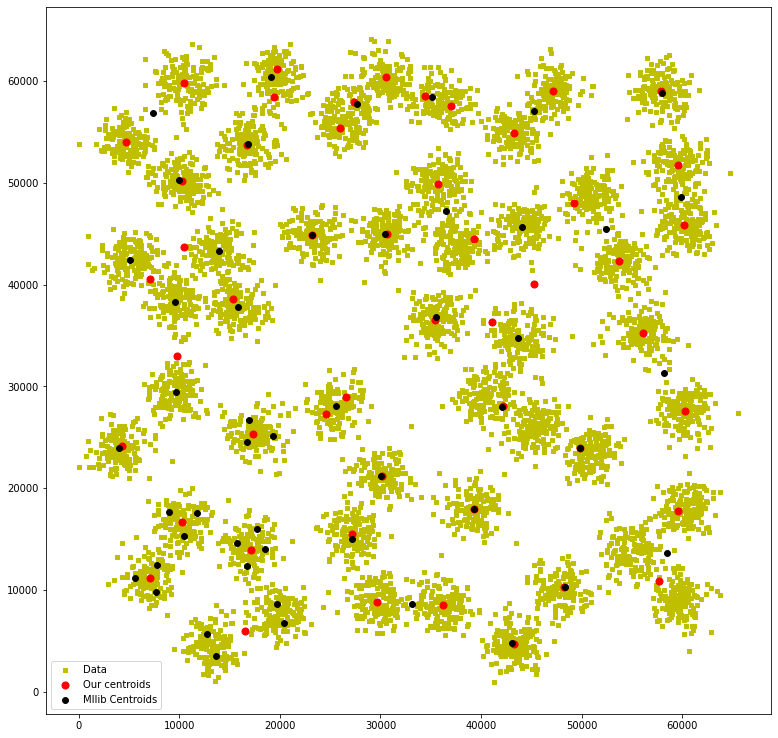

In [16]:
xdata, ydata = np.hsplit(array(parsed_data.collect()), 2)

x, y = np.hsplit(array(final_centroids), 2) 
fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(111)


x1, y1 = zip(*mllib_clusters.centers)

data_scatter = ax1.scatter(xdata, ydata, s=10, color='y', marker="s")
our_centroids = ax1.scatter(x, y, s=50, color='r', marker="o")
mllib_centoids = ax1.scatter(x1, y1, s=35, color='k', marker="o")

plt.legend([data_scatter,our_centroids,mllib_centoids], ['Data', 'Our centroids', 'Mllib Centroids'])

***
## PKmeans evaluation on large sets
***

### KDD Cup 1999 data set
Load and clean the data set. <br>
Then, use built in spark stats to analize the data set.

In [17]:
kdd_data = sc.textFile("data/kddcup1999")
kdd_parsed_data = kdd_data.map(lambda line: line.strip().split(','))
kdd_parsed_data.cache()

PythonRDD[172] at RDD at PythonRDD.scala:53

In [18]:
kdd_fields = [  "duration",
                "protocol_type",
                "service",
                "flag",
                "src_bytes",
                "dst_bytes",
                "land",
                "wrong_fragment",
                "urgent",
                "hot",
                "num_failed_logins",
                "logged_in",
                "num_compromised",
                "root_shell",
                "su_attempted",
                "num_root",
                "num_file_creations",
                "num_shells",
                "num_access_files",
                "num_outbound_cmds",
                "is_host_login",
                "is_guest_login",
                "count",
                "srv_count",
                "serror_rate",
                "srv_serror_rate",
                "rerror_rate",
                "srv_rerror_rate",
                "same_srv_rate",
                "diff_srv_rate",
                "srv_diff_host_rate",
                "dst_host_count",
                "dst_host_srv_count",
                "dst_host_same_srv_rate",
                "dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate",
                "dst_host_serror_rate",
                "dst_host_srv_serror_rate",
                "dst_host_rerror_rate",
                "dst_host_srv_rerror_rate"
]

In [19]:
kdd_parsed_data.take(10)

[['0',
  'tcp',
  'http',
  'SF',
  '215',
  '45076',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '1',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '0',
  '0',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  'normal.'],
 ['0',
  'tcp',
  'http',
  'SF',
  '162',
  '4528',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '2',
  '2',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '1',
  '1',
  '1.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  'normal.'],
 ['0',
  'tcp',
  'http',
  'SF',
  '236',
  '1228',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '1',
  '0.00',
  '0.00',
  '0.00',
  '0.00',
  '1.00',
  '0.00',
  '0.00',
  '2',
  '2',
  '1.00',
  '0.00',
  

We will use only the numeric fields for clustering.

In [20]:
numeric_fields = [
    "duration",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
]

In [21]:
fields_filter = [1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
len(fields_filter)

42

In [22]:
def parse_kdd_line_filter_fields(line):
    split_line = line.strip().split(',')
    return array(list(map(float, compress(split_line, fields_filter))))
    
    
kdd_data = sc.textFile("data/kddcup1999")
kdd_parsed_data_clean = kdd_data.map(parse_kdd_line_filter_fields)
kdd_parsed_data_clean.cache()



PythonRDD[176] at RDD at PythonRDD.scala:53

In [23]:
sc.setLogLevel('INFO')

In [ ]:
kdd_centroids = pkmeans(kdd_parsed_data_clean, 150)
sc.show_profiles()

21/09/18 20:59:11 INFO FileInputFormat: Total input files to process : 1
21/09/18 20:59:11 INFO SparkContext: Starting job: takeSample at /tmp/ipykernel_70530/3442377565.py:45
21/09/18 20:59:11 INFO DAGScheduler: Got job 124 (takeSample at /tmp/ipykernel_70530/3442377565.py:45) with 23 output partitions
21/09/18 20:59:11 INFO DAGScheduler: Final stage: ResultStage 152 (takeSample at /tmp/ipykernel_70530/3442377565.py:45)
21/09/18 20:59:11 INFO DAGScheduler: Parents of final stage: List()
21/09/18 20:59:11 INFO DAGScheduler: Missing parents: List()
21/09/18 20:59:11 INFO DAGScheduler: Submitting ResultStage 152 (PythonRDD[177] at takeSample at /tmp/ipykernel_70530/3442377565.py:45), which has no missing parents
21/09/18 20:59:11 INFO MemoryStore: Block broadcast_283 stored as values in memory (estimated size 9.7 KiB, free 429.0 MiB)
21/09/18 20:59:11 INFO MemoryStore: Block broadcast_283_piece0 stored as bytes in memory (estimated size 5.3 KiB, free 429.0 MiB)
21/09/18 20:59:12 INFO Blo

21/09/18 20:59:19 INFO PythonRunner: Times: total = 467, boot = -36, init = 36, finish = 467
21/09/18 20:59:19 INFO Executor: Finished task 6.0 in stage 152.0 (TID 306). 8807 bytes result sent to driver
21/09/18 20:59:19 INFO TaskSetManager: Starting task 10.0 in stage 152.0 (TID 310) (192.168.48.128, executor driver, partition 10, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 20:59:19 INFO TaskSetManager: Finished task 6.0 in stage 152.0 (TID 306) in 3724 ms on 192.168.48.128 (executor driver) (7/23)
21/09/18 20:59:19 INFO Executor: Running task 10.0 in stage 152.0 (TID 310)
21/09/18 20:59:19 INFO HadoopRDD: Input split: file:/home/anton/sparkworkspace/data/kddcup1999:335544320+33554432
21/09/18 20:59:19 INFO PythonRunner: Times: total = 710, boot = -36, init = 38, finish = 708
21/09/18 20:59:19 INFO Executor: Finished task 7.0 in stage 152.0 (TID 307). 8807 bytes result sent to driver
21/09/18 20:59:19 INFO TaskSetManager: Starting task 11.0 in stage 152.0 (TID 31

21/09/18 20:59:25 INFO PythonRunner: Times: total = 456, boot = -42, init = 42, finish = 456
21/09/18 20:59:25 INFO Executor: Finished task 14.0 in stage 152.0 (TID 314). 8807 bytes result sent to driver
21/09/18 20:59:25 INFO TaskSetManager: Starting task 18.0 in stage 152.0 (TID 318) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 20:59:25 INFO TaskSetManager: Finished task 14.0 in stage 152.0 (TID 314) in 3388 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 20:59:25 INFO Executor: Running task 18.0 in stage 152.0 (TID 318)
21/09/18 20:59:25 INFO HadoopRDD: Input split: file:/home/anton/sparkworkspace/data/kddcup1999:603979776+33554432
21/09/18 20:59:26 INFO PythonRunner: Times: total = 3190, boot = -13, init = 27, finish = 3176
21/09/18 20:59:26 INFO MemoryStore: Block rdd_176_15 stored as values in memory (estimated size 3.3 MiB, free 383.8 MiB)
21/09/18 20:59:26 INFO BlockManagerInfo: Added rdd_176_15 in mem

21/09/18 20:59:32 INFO BlockManagerInfo: Removed broadcast_283_piece0 on 192.168.48.128:35295 in memory (size: 5.3 KiB, free: 363.5 MiB)
21/09/18 20:59:33 INFO PythonRunner: Times: total = 576, boot = -21, init = 32, finish = 565
21/09/18 20:59:33 INFO Executor: Finished task 0.0 in stage 153.0 (TID 323). 10888 bytes result sent to driver
21/09/18 20:59:33 INFO TaskSetManager: Starting task 4.0 in stage 153.0 (TID 327) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 20:59:33 INFO TaskSetManager: Finished task 0.0 in stage 153.0 (TID 323) in 582 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 20:59:33 INFO Executor: Running task 4.0 in stage 153.0 (TID 327)
21/09/18 20:59:33 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 20:59:33 INFO PythonRunner: Times: total = 608, boot = -322, init = 330, finish = 600
21/09/18 20:59:33 INFO Executor: Finished task 3.0 in stage 153.0 (TID 326). 9427 bytes result sent t

21/09/18 20:59:34 INFO PythonRunner: Times: total = 493, boot = 22, init = 0, finish = 471
21/09/18 20:59:34 INFO Executor: Finished task 14.0 in stage 153.0 (TID 337). 9794 bytes result sent to driver
21/09/18 20:59:34 INFO TaskSetManager: Starting task 18.0 in stage 153.0 (TID 341) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 20:59:34 INFO TaskSetManager: Finished task 14.0 in stage 153.0 (TID 337) in 496 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 20:59:34 INFO Executor: Running task 18.0 in stage 153.0 (TID 341)
21/09/18 20:59:34 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 20:59:35 INFO PythonRunner: Times: total = 483, boot = 3, init = 9, finish = 471
21/09/18 20:59:35 INFO Executor: Finished task 15.0 in stage 153.0 (TID 338). 9794 bytes result sent to driver
21/09/18 20:59:35 INFO TaskSetManager: Starting task 19.0 in stage 153.0 (TID 342) (192.168.48.128, executor driver, partition 1

21/09/18 20:59:35 INFO BlockManagerInfo: Removed broadcast_284_piece0 on 192.168.48.128:35295 in memory (size: 4.5 KiB, free: 363.5 MiB)
21/09/18 20:59:52 INFO PythonRunner: Times: total = 16639, boot = -321, init = 322, finish = 16638
21/09/18 20:59:52 INFO Executor: Finished task 0.0 in stage 154.0 (TID 346). 54833 bytes result sent to driver
21/09/18 20:59:52 INFO TaskSetManager: Starting task 4.0 in stage 154.0 (TID 350) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 20:59:52 INFO Executor: Running task 4.0 in stage 154.0 (TID 350)
21/09/18 20:59:52 INFO TaskSetManager: Finished task 0.0 in stage 154.0 (TID 346) in 16643 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 20:59:52 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 20:59:52 INFO PythonRunner: Times: total = 17021, boot = -37, init = 161, finish = 16897
21/09/18 20:59:52 INFO Executor: Finished task 1.0 in stage 154.0 (TID 347). 66550 bytes r

21/09/18 21:00:23 INFO PythonRunner: Times: total = 10116, boot = 5, init = 3, finish = 10108
21/09/18 21:00:23 INFO Executor: Finished task 12.0 in stage 154.0 (TID 358). 15372 bytes result sent to driver
21/09/18 21:00:23 INFO TaskSetManager: Starting task 16.0 in stage 154.0 (TID 362) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:00:23 INFO TaskSetManager: Finished task 12.0 in stage 154.0 (TID 358) in 10118 ms on 192.168.48.128 (executor driver) (13/23)
21/09/18 21:00:23 INFO Executor: Running task 16.0 in stage 154.0 (TID 362)
21/09/18 21:00:23 INFO BlockManager: Found block rdd_176_16 locally
21/09/18 21:00:24 INFO PythonRunner: Times: total = 9858, boot = 9, init = 10, finish = 9839
21/09/18 21:00:24 INFO Executor: Finished task 13.0 in stage 154.0 (TID 359). 15372 bytes result sent to driver
21/09/18 21:00:24 INFO TaskSetManager: Starting task 17.0 in stage 154.0 (TID 363) (192.168.48.128, executor driver, p

Iteration #1	Distance between old and new centroids: 15272212.3216	Iteration took: 68.0160 sec


21/09/18 21:00:53 INFO PythonRunner: Times: total = 9611, boot = -35, init = 44, finish = 9602
21/09/18 21:00:53 INFO Executor: Finished task 2.0 in stage 155.0 (TID 371). 71812 bytes result sent to driver
21/09/18 21:00:53 INFO TaskSetManager: Starting task 4.0 in stage 155.0 (TID 373) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:00:53 INFO TaskSetManager: Finished task 2.0 in stage 155.0 (TID 371) in 9614 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:00:53 INFO Executor: Running task 4.0 in stage 155.0 (TID 373)
21/09/18 21:00:53 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:00:53 INFO PythonRunner: Times: total = 9660, boot = -9667, init = 9669, finish = 9658
21/09/18 21:00:53 INFO Executor: Finished task 3.0 in stage 155.0 (TID 372). 71812 bytes result sent to driver
21/09/18 21:00:53 INFO TaskSetManager: Starting task 5.0 in stage 155.0 (TID 374) (192.168.48.128, executor driver, part

21/09/18 21:01:22 INFO PythonRunner: Times: total = 9508, boot = 4, init = 11, finish = 9493
21/09/18 21:01:22 INFO Executor: Finished task 14.0 in stage 155.0 (TID 383). 14164 bytes result sent to driver
21/09/18 21:01:22 INFO TaskSetManager: Starting task 18.0 in stage 155.0 (TID 387) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:01:22 INFO Executor: Running task 18.0 in stage 155.0 (TID 387)
21/09/18 21:01:22 INFO TaskSetManager: Finished task 14.0 in stage 155.0 (TID 383) in 9511 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:01:22 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:01:22 INFO PythonRunner: Times: total = 9627, boot = 21, init = 0, finish = 9606
21/09/18 21:01:22 INFO Executor: Finished task 15.0 in stage 155.0 (TID 384). 73121 bytes result sent to driver
21/09/18 21:01:22 INFO TaskSetManager: Starting task 19.0 in stage 155.0 (TID 388) (192.168.48.128, executor driver, par

Iteration #2	Distance between old and new centroids: 162714663.0127	Iteration took: 57.7396 sec


21/09/18 21:01:51 INFO PythonRunner: Times: total = 9855, boot = -37, init = 67, finish = 9825
21/09/18 21:01:51 INFO Executor: Finished task 2.0 in stage 156.0 (TID 394). 73934 bytes result sent to driver
21/09/18 21:01:51 INFO TaskSetManager: Starting task 4.0 in stage 156.0 (TID 396) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:01:51 INFO TaskSetManager: Finished task 2.0 in stage 156.0 (TID 394) in 9860 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:01:51 INFO Executor: Running task 4.0 in stage 156.0 (TID 396)
21/09/18 21:01:51 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:01:51 INFO PythonRunner: Times: total = 9877, boot = -8257, init = 8270, finish = 9864
21/09/18 21:01:51 INFO Executor: Finished task 0.0 in stage 156.0 (TID 392). 53815 bytes result sent to driver
21/09/18 21:01:51 INFO TaskSetManager: Starting task 5.0 in stage 156.0 (TID 397) (192.168.48.128, executor driver, part

21/09/18 21:02:20 INFO PythonRunner: Times: total = 9399, boot = 5, init = 3, finish = 9391
21/09/18 21:02:20 INFO Executor: Finished task 13.0 in stage 156.0 (TID 405). 14164 bytes result sent to driver
21/09/18 21:02:20 INFO TaskSetManager: Starting task 17.0 in stage 156.0 (TID 409) (192.168.48.128, executor driver, partition 17, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:02:20 INFO TaskSetManager: Finished task 13.0 in stage 156.0 (TID 405) in 9402 ms on 192.168.48.128 (executor driver) (14/23)
21/09/18 21:02:20 INFO Executor: Running task 17.0 in stage 156.0 (TID 409)
21/09/18 21:02:20 INFO BlockManager: Found block rdd_176_17 locally
21/09/18 21:02:20 INFO PythonRunner: Times: total = 9442, boot = 5, init = 3, finish = 9434
21/09/18 21:02:20 INFO Executor: Finished task 14.0 in stage 156.0 (TID 406). 14164 bytes result sent to driver
21/09/18 21:02:20 INFO TaskSetManager: Starting task 18.0 in stage 156.0 (TID 410) (192.168.48.128, executor driver, parti

Iteration #3	Distance between old and new centroids: 362081566.4092	Iteration took: 57.5882 sec


21/09/18 21:02:49 INFO PythonRunner: Times: total = 9834, boot = -7914, init = 7920, finish = 9828
21/09/18 21:02:49 INFO Executor: Finished task 1.0 in stage 157.0 (TID 416). 67568 bytes result sent to driver
21/09/18 21:02:49 INFO TaskSetManager: Starting task 4.0 in stage 157.0 (TID 419) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:02:49 INFO TaskSetManager: Finished task 1.0 in stage 157.0 (TID 416) in 9842 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:02:49 INFO Executor: Running task 4.0 in stage 157.0 (TID 419)
21/09/18 21:02:49 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:02:49 INFO PythonRunner: Times: total = 9852, boot = -73, init = 98, finish = 9827
21/09/18 21:02:49 INFO Executor: Finished task 0.0 in stage 157.0 (TID 415). 53815 bytes result sent to driver
21/09/18 21:02:49 INFO TaskSetManager: Starting task 5.0 in stage 157.0 (TID 420) (192.168.48.128, executor driver, part

21/09/18 21:03:18 INFO PythonRunner: Times: total = 9265, boot = 4, init = 3, finish = 9258
21/09/18 21:03:18 INFO Executor: Finished task 14.0 in stage 157.0 (TID 429). 13102 bytes result sent to driver
21/09/18 21:03:18 INFO TaskSetManager: Starting task 18.0 in stage 157.0 (TID 433) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:03:18 INFO Executor: Running task 18.0 in stage 157.0 (TID 433)
21/09/18 21:03:18 INFO TaskSetManager: Finished task 14.0 in stage 157.0 (TID 429) in 9267 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:03:18 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:03:18 INFO PythonRunner: Times: total = 9565, boot = 3, init = 3, finish = 9559
21/09/18 21:03:18 INFO Executor: Finished task 15.0 in stage 157.0 (TID 430). 75243 bytes result sent to driver
21/09/18 21:03:18 INFO TaskSetManager: Starting task 19.0 in stage 157.0 (TID 434) (192.168.48.128, executor driver, parti

Iteration #4	Distance between old and new centroids: 207053615.7492	Iteration took: 57.7161 sec


21/09/18 21:03:37 INFO BlockManagerInfo: Removed broadcast_292_piece0 on 192.168.48.128:35295 in memory (size: 5.6 KiB, free: 363.4 MiB)
21/09/18 21:03:46 INFO PythonRunner: Times: total = 9413, boot = -35, init = 38, finish = 9410
21/09/18 21:03:46 INFO Executor: Finished task 2.0 in stage 158.0 (TID 440). 77160 bytes result sent to driver
21/09/18 21:03:46 INFO TaskSetManager: Starting task 4.0 in stage 158.0 (TID 442) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:03:46 INFO TaskSetManager: Finished task 2.0 in stage 158.0 (TID 440) in 9418 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:03:46 INFO Executor: Running task 4.0 in stage 158.0 (TID 442)
21/09/18 21:03:46 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:03:46 INFO PythonRunner: Times: total = 9625, boot = -158, init = 197, finish = 9586
21/09/18 21:03:46 INFO Executor: Finished task 1.0 in stage 158.0 (TID 439). 68672 bytes result 

21/09/18 21:04:14 INFO PythonRunner: Times: total = 9200, boot = 6, init = 4, finish = 9190
21/09/18 21:04:14 INFO Executor: Finished task 12.0 in stage 158.0 (TID 450). 13102 bytes result sent to driver
21/09/18 21:04:14 INFO TaskSetManager: Starting task 16.0 in stage 158.0 (TID 454) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:04:14 INFO TaskSetManager: Finished task 12.0 in stage 158.0 (TID 450) in 9202 ms on 192.168.48.128 (executor driver) (13/23)
21/09/18 21:04:14 INFO Executor: Running task 16.0 in stage 158.0 (TID 454)
21/09/18 21:04:14 INFO BlockManager: Found block rdd_176_16 locally
21/09/18 21:04:14 INFO PythonRunner: Times: total = 9180, boot = 3, init = 3, finish = 9174
21/09/18 21:04:14 INFO Executor: Finished task 13.0 in stage 158.0 (TID 451). 13102 bytes result sent to driver
21/09/18 21:04:14 INFO TaskSetManager: Starting task 17.0 in stage 158.0 (TID 455) (192.168.48.128, executor driver, parti

Iteration #5	Distance between old and new centroids: 57225965.4215	Iteration took: 56.3413 sec


21/09/18 21:04:33 INFO BlockManagerInfo: Removed broadcast_287_piece0 on 192.168.48.128:35295 in memory (size: 13.6 KiB, free: 363.4 MiB)
21/09/18 21:04:33 INFO BlockManagerInfo: Removed broadcast_289_piece0 on 192.168.48.128:35295 in memory (size: 13.4 KiB, free: 363.4 MiB)
21/09/18 21:04:33 INFO BlockManagerInfo: Removed broadcast_291_piece0 on 192.168.48.128:35295 in memory (size: 13.5 KiB, free: 363.4 MiB)
21/09/18 21:04:33 INFO BlockManagerInfo: Removed broadcast_294_piece0 on 192.168.48.128:35295 in memory (size: 5.6 KiB, free: 363.4 MiB)
21/09/18 21:04:33 INFO BlockManagerInfo: Removed broadcast_285_piece0 on 192.168.48.128:35295 in memory (size: 5.1 KiB, free: 363.4 MiB)
21/09/18 21:04:42 INFO PythonRunner: Times: total = 9474, boot = -8113, init = 8118, finish = 9469
21/09/18 21:04:42 INFO Executor: Finished task 2.0 in stage 159.0 (TID 463). 74995 bytes result sent to driver
21/09/18 21:04:42 INFO TaskSetManager: Starting task 4.0 in stage 159.0 (TID 465) (192.168.48.128, exe

21/09/18 21:05:10 INFO PythonRunner: Times: total = 9337, boot = 4, init = 3, finish = 9330
21/09/18 21:05:10 INFO Executor: Finished task 12.0 in stage 159.0 (TID 473). 13102 bytes result sent to driver
21/09/18 21:05:10 INFO TaskSetManager: Starting task 16.0 in stage 159.0 (TID 477) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:05:10 INFO TaskSetManager: Finished task 12.0 in stage 159.0 (TID 473) in 9341 ms on 192.168.48.128 (executor driver) (13/23)
21/09/18 21:05:10 INFO Executor: Running task 16.0 in stage 159.0 (TID 477)
21/09/18 21:05:10 INFO BlockManager: Found block rdd_176_16 locally
21/09/18 21:05:11 INFO PythonRunner: Times: total = 9369, boot = 6, init = 3, finish = 9360
21/09/18 21:05:11 INFO Executor: Finished task 14.0 in stage 159.0 (TID 475). 13102 bytes result sent to driver
21/09/18 21:05:11 INFO TaskSetManager: Starting task 17.0 in stage 159.0 (TID 478) (192.168.48.128, executor driver, parti

Iteration #6	Distance between old and new centroids: 43464195.0291	Iteration took: 56.5277 sec


21/09/18 21:05:29 INFO BlockManagerInfo: Removed broadcast_296_piece0 on 192.168.48.128:35295 in memory (size: 5.6 KiB, free: 363.4 MiB)
21/09/18 21:05:39 INFO PythonRunner: Times: total = 9527, boot = -9155, init = 9156, finish = 9526
21/09/18 21:05:39 INFO Executor: Finished task 3.0 in stage 160.0 (TID 487). 72873 bytes result sent to driver
21/09/18 21:05:39 INFO TaskSetManager: Starting task 4.0 in stage 160.0 (TID 488) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:05:39 INFO Executor: Running task 4.0 in stage 160.0 (TID 488)
21/09/18 21:05:39 INFO TaskSetManager: Finished task 3.0 in stage 160.0 (TID 487) in 9529 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:05:39 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:05:39 INFO PythonRunner: Times: total = 9759, boot = -34, init = 38, finish = 9755
21/09/18 21:05:39 INFO Executor: Finished task 1.0 in stage 160.0 (TID 485). 66550 bytes resul

21/09/18 21:06:07 INFO PythonRunner: Times: total = 9092, boot = 4, init = 3, finish = 9085
21/09/18 21:06:07 INFO Executor: Finished task 12.0 in stage 160.0 (TID 496). 13102 bytes result sent to driver
21/09/18 21:06:07 INFO TaskSetManager: Starting task 16.0 in stage 160.0 (TID 500) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:06:07 INFO Executor: Running task 16.0 in stage 160.0 (TID 500)
21/09/18 21:06:07 INFO TaskSetManager: Finished task 12.0 in stage 160.0 (TID 496) in 9095 ms on 192.168.48.128 (executor driver) (13/23)
21/09/18 21:06:07 INFO BlockManager: Found block rdd_176_16 locally
21/09/18 21:06:07 INFO PythonRunner: Times: total = 9177, boot = 2, init = 1, finish = 9174
21/09/18 21:06:07 INFO Executor: Finished task 13.0 in stage 160.0 (TID 497). 13102 bytes result sent to driver
21/09/18 21:06:07 INFO TaskSetManager: Starting task 17.0 in stage 160.0 (TID 501) (192.168.48.128, executor driver, parti

Iteration #7	Distance between old and new centroids: 187950775.3808	Iteration took: 56.2628 sec


21/09/18 21:06:35 INFO PythonRunner: Times: total = 9399, boot = -9079, init = 9081, finish = 9397
21/09/18 21:06:35 INFO Executor: Finished task 2.0 in stage 161.0 (TID 509). 76056 bytes result sent to driver
21/09/18 21:06:35 INFO TaskSetManager: Starting task 4.0 in stage 161.0 (TID 511) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:06:35 INFO TaskSetManager: Finished task 2.0 in stage 161.0 (TID 509) in 9401 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:06:35 INFO Executor: Running task 4.0 in stage 161.0 (TID 511)
21/09/18 21:06:35 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:06:35 INFO PythonRunner: Times: total = 9608, boot = -8036, init = 8065, finish = 9579
21/09/18 21:06:35 INFO Executor: Finished task 3.0 in stage 161.0 (TID 510). 73934 bytes result sent to driver
21/09/18 21:06:35 INFO TaskSetManager: Starting task 5.0 in stage 161.0 (TID 512) (192.168.48.128, executor driver, 

21/09/18 21:07:03 INFO PythonRunner: Times: total = 9288, boot = 4, init = 1, finish = 9283
21/09/18 21:07:03 INFO Executor: Finished task 12.0 in stage 161.0 (TID 519). 13102 bytes result sent to driver
21/09/18 21:07:03 INFO TaskSetManager: Starting task 17.0 in stage 161.0 (TID 524) (192.168.48.128, executor driver, partition 17, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:07:03 INFO TaskSetManager: Finished task 12.0 in stage 161.0 (TID 519) in 9291 ms on 192.168.48.128 (executor driver) (14/23)
21/09/18 21:07:03 INFO Executor: Running task 17.0 in stage 161.0 (TID 524)
21/09/18 21:07:03 INFO BlockManager: Found block rdd_176_17 locally
21/09/18 21:07:03 INFO PythonRunner: Times: total = 9061, boot = 3, init = 1, finish = 9057
21/09/18 21:07:03 INFO Executor: Finished task 14.0 in stage 161.0 (TID 521). 13102 bytes result sent to driver
21/09/18 21:07:03 INFO TaskSetManager: Starting task 18.0 in stage 161.0 (TID 525) (192.168.48.128, executor driver, parti

Iteration #8	Distance between old and new centroids: 343878966.8206	Iteration took: 56.0220 sec


21/09/18 21:07:31 INFO PythonRunner: Times: total = 9410, boot = -7993, init = 7997, finish = 9406
21/09/18 21:07:31 INFO Executor: Finished task 2.0 in stage 162.0 (TID 532). 74995 bytes result sent to driver
21/09/18 21:07:31 INFO TaskSetManager: Starting task 4.0 in stage 162.0 (TID 534) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:07:31 INFO Executor: Running task 4.0 in stage 162.0 (TID 534)
21/09/18 21:07:31 INFO TaskSetManager: Finished task 2.0 in stage 162.0 (TID 532) in 9412 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:07:31 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:07:31 INFO PythonRunner: Times: total = 9615, boot = -44, init = 65, finish = 9594
21/09/18 21:07:31 INFO Executor: Finished task 3.0 in stage 162.0 (TID 533). 73977 bytes result sent to driver
21/09/18 21:07:31 INFO TaskSetManager: Starting task 5.0 in stage 162.0 (TID 535) (192.168.48.128, executor driver, part

21/09/18 21:07:59 INFO PythonRunner: Times: total = 9025, boot = 2, init = 3, finish = 9020
21/09/18 21:07:59 INFO Executor: Finished task 14.0 in stage 162.0 (TID 544). 13102 bytes result sent to driver
21/09/18 21:07:59 INFO TaskSetManager: Starting task 17.0 in stage 162.0 (TID 547) (192.168.48.128, executor driver, partition 17, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:07:59 INFO TaskSetManager: Finished task 14.0 in stage 162.0 (TID 544) in 9028 ms on 192.168.48.128 (executor driver) (14/23)
21/09/18 21:07:59 INFO Executor: Running task 17.0 in stage 162.0 (TID 547)
21/09/18 21:07:59 INFO BlockManager: Found block rdd_176_17 locally
21/09/18 21:07:59 INFO PythonRunner: Times: total = 9116, boot = 6, init = 3, finish = 9107
21/09/18 21:07:59 INFO Executor: Finished task 13.0 in stage 162.0 (TID 543). 13102 bytes result sent to driver
21/09/18 21:07:59 INFO TaskSetManager: Starting task 18.0 in stage 162.0 (TID 548) (192.168.48.128, executor driver, parti

Iteration #9	Distance between old and new centroids: 827702859.9001	Iteration took: 56.8342 sec


21/09/18 21:08:18 INFO BlockManager: Found block rdd_176_0 locally
21/09/18 21:08:19 INFO BlockManagerInfo: Removed broadcast_302_piece0 on 192.168.48.128:35295 in memory (size: 5.6 KiB, free: 363.4 MiB)
21/09/18 21:08:28 INFO PythonRunner: Times: total = 9495, boot = -191, init = 202, finish = 9484
21/09/18 21:08:28 INFO Executor: Finished task 1.0 in stage 163.0 (TID 554). 66507 bytes result sent to driver
21/09/18 21:08:28 INFO TaskSetManager: Starting task 4.0 in stage 163.0 (TID 557) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:08:28 INFO TaskSetManager: Finished task 1.0 in stage 163.0 (TID 554) in 9500 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:08:28 INFO Executor: Running task 4.0 in stage 163.0 (TID 557)
21/09/18 21:08:28 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:08:28 INFO PythonRunner: Times: total = 9673, boot = -8151, init = 8171, finish = 9653
21/09/18 21:08:28 INFO Ex

21/09/18 21:08:55 INFO PythonRunner: Times: total = 9001, boot = 5, init = 2, finish = 8994
21/09/18 21:08:55 INFO Executor: Finished task 12.0 in stage 163.0 (TID 565). 11891 bytes result sent to driver
21/09/18 21:08:55 INFO TaskSetManager: Starting task 16.0 in stage 163.0 (TID 569) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:08:55 INFO TaskSetManager: Finished task 12.0 in stage 163.0 (TID 565) in 9004 ms on 192.168.48.128 (executor driver) (13/23)
21/09/18 21:08:55 INFO Executor: Running task 16.0 in stage 163.0 (TID 569)
21/09/18 21:08:55 INFO BlockManager: Found block rdd_176_16 locally
21/09/18 21:08:55 INFO PythonRunner: Times: total = 9119, boot = 5, init = 3, finish = 9111
21/09/18 21:08:55 INFO Executor: Finished task 13.0 in stage 163.0 (TID 566). 11891 bytes result sent to driver
21/09/18 21:08:55 INFO TaskSetManager: Starting task 17.0 in stage 163.0 (TID 570) (192.168.48.128, executor driver, parti

Iteration #10	Distance between old and new centroids: 47655292.7411	Iteration took: 56.0209 sec


21/09/18 21:09:24 INFO PythonRunner: Times: total = 9448, boot = -36, init = 51, finish = 9433
21/09/18 21:09:24 INFO Executor: Finished task 2.0 in stage 164.0 (TID 578). 75038 bytes result sent to driver
21/09/18 21:09:24 INFO TaskSetManager: Starting task 4.0 in stage 164.0 (TID 580) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:09:24 INFO TaskSetManager: Finished task 2.0 in stage 164.0 (TID 578) in 9455 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:09:24 INFO Executor: Running task 4.0 in stage 164.0 (TID 580)
21/09/18 21:09:24 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:09:24 INFO PythonRunner: Times: total = 9650, boot = -9319, init = 9324, finish = 9645
21/09/18 21:09:24 INFO Executor: Finished task 1.0 in stage 164.0 (TID 577). 67568 bytes result sent to driver
21/09/18 21:09:24 INFO TaskSetManager: Starting task 5.0 in stage 164.0 (TID 581) (192.168.48.128, executor driver, part

21/09/18 21:09:52 INFO PythonRunner: Times: total = 9093, boot = 3, init = 1, finish = 9089
21/09/18 21:09:52 INFO Executor: Finished task 14.0 in stage 164.0 (TID 590). 11891 bytes result sent to driver
21/09/18 21:09:52 INFO TaskSetManager: Finished task 14.0 in stage 164.0 (TID 590) in 9095 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:09:52 INFO TaskSetManager: Starting task 18.0 in stage 164.0 (TID 594) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:09:52 INFO Executor: Running task 18.0 in stage 164.0 (TID 594)
21/09/18 21:09:52 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:09:52 INFO PythonRunner: Times: total = 9330, boot = 3, init = 2, finish = 9325
21/09/18 21:09:52 INFO Executor: Finished task 15.0 in stage 164.0 (TID 591). 75243 bytes result sent to driver
21/09/18 21:09:52 INFO TaskSetManager: Starting task 19.0 in stage 164.0 (TID 595) (192.168.48.128, executor driver, parti

Iteration #11	Distance between old and new centroids: 29957029.7611	Iteration took: 55.6092 sec


21/09/18 21:10:20 INFO PythonRunner: Times: total = 9502, boot = -126, init = 156, finish = 9472
21/09/18 21:10:20 INFO Executor: Finished task 1.0 in stage 165.0 (TID 600). 66550 bytes result sent to driver
21/09/18 21:10:20 INFO TaskSetManager: Starting task 4.0 in stage 165.0 (TID 603) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:10:20 INFO Executor: Running task 4.0 in stage 165.0 (TID 603)
21/09/18 21:10:20 INFO TaskSetManager: Finished task 1.0 in stage 165.0 (TID 600) in 9506 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:10:20 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:10:20 INFO PythonRunner: Times: total = 9581, boot = -8005, init = 8008, finish = 9578
21/09/18 21:10:20 INFO Executor: Finished task 0.0 in stage 165.0 (TID 599). 54833 bytes result sent to driver
21/09/18 21:10:20 INFO TaskSetManager: Starting task 5.0 in stage 165.0 (TID 604) (192.168.48.128, executor driver, pa

21/09/18 21:10:48 INFO PythonRunner: Times: total = 9428, boot = 3, init = 3, finish = 9422
21/09/18 21:10:48 INFO Executor: Finished task 14.0 in stage 165.0 (TID 613). 11891 bytes result sent to driver
21/09/18 21:10:48 INFO TaskSetManager: Starting task 18.0 in stage 165.0 (TID 617) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:10:48 INFO TaskSetManager: Finished task 14.0 in stage 165.0 (TID 613) in 9431 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:10:48 INFO Executor: Running task 18.0 in stage 165.0 (TID 617)
21/09/18 21:10:48 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:10:48 INFO PythonRunner: Times: total = 10104, boot = 4, init = 2, finish = 10098
21/09/18 21:10:48 INFO Executor: Finished task 15.0 in stage 165.0 (TID 614). 77365 bytes result sent to driver
21/09/18 21:10:48 INFO TaskSetManager: Starting task 19.0 in stage 165.0 (TID 618) (192.168.48.128, executor driver, par

Iteration #12	Distance between old and new centroids: 93417710.9953	Iteration took: 56.1467 sec


21/09/18 21:11:06 INFO MemoryStore: Block broadcast_309 stored as values in memory (estimated size 208.0 B, free 362.8 MiB)
21/09/18 21:11:06 INFO MemoryStore: Block broadcast_309_piece0 stored as bytes in memory (estimated size 13.9 KiB, free 362.8 MiB)
21/09/18 21:11:06 INFO BlockManagerInfo: Added broadcast_309_piece0 in memory on 192.168.48.128:35295 (size: 13.9 KiB, free: 363.3 MiB)
21/09/18 21:11:06 INFO SparkContext: Created broadcast 309 from broadcast at <unknown>:0
21/09/18 21:11:06 INFO SparkContext: Starting job: collect at /tmp/ipykernel_70530/3442377565.py:53
21/09/18 21:11:06 INFO DAGScheduler: Got job 138 (collect at /tmp/ipykernel_70530/3442377565.py:53) with 23 output partitions
21/09/18 21:11:06 INFO DAGScheduler: Final stage: ResultStage 166 (collect at /tmp/ipykernel_70530/3442377565.py:53)
21/09/18 21:11:06 INFO DAGScheduler: Parents of final stage: List()
21/09/18 21:11:06 INFO DAGScheduler: Missing parents: List()
21/09/18 21:11:06 INFO DAGScheduler: Submitting 

21/09/18 21:11:34 INFO PythonRunner: Times: total = 9105, boot = 5, init = 3, finish = 9097
21/09/18 21:11:34 INFO Executor: Finished task 8.0 in stage 166.0 (TID 630). 13102 bytes result sent to driver
21/09/18 21:11:34 INFO TaskSetManager: Starting task 12.0 in stage 166.0 (TID 634) (192.168.48.128, executor driver, partition 12, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:11:34 INFO Executor: Running task 12.0 in stage 166.0 (TID 634)
21/09/18 21:11:34 INFO TaskSetManager: Finished task 8.0 in stage 166.0 (TID 630) in 9107 ms on 192.168.48.128 (executor driver) (9/23)
21/09/18 21:11:34 INFO BlockManager: Found block rdd_176_12 locally
21/09/18 21:11:34 INFO PythonRunner: Times: total = 8980, boot = 5, init = 3, finish = 8972
21/09/18 21:11:34 INFO Executor: Finished task 9.0 in stage 166.0 (TID 631). 11891 bytes result sent to driver
21/09/18 21:11:34 INFO TaskSetManager: Starting task 13.0 in stage 166.0 (TID 635) (192.168.48.128, executor driver, partition

Iteration #13	Distance between old and new centroids: 22282093.8196	Iteration took: 55.7526 sec


21/09/18 21:12:02 INFO BlockManagerInfo: Removed broadcast_310_piece0 on 192.168.48.128:35295 in memory (size: 5.6 KiB, free: 363.3 MiB)
21/09/18 21:12:11 INFO PythonRunner: Times: total = 9376, boot = -165, init = 172, finish = 9369
21/09/18 21:12:11 INFO Executor: Finished task 2.0 in stage 167.0 (TID 647). 73977 bytes result sent to driver
21/09/18 21:12:11 INFO TaskSetManager: Starting task 4.0 in stage 167.0 (TID 649) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:12:11 INFO TaskSetManager: Finished task 2.0 in stage 167.0 (TID 647) in 9379 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:12:11 INFO Executor: Running task 4.0 in stage 167.0 (TID 649)
21/09/18 21:12:11 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:12:12 INFO PythonRunner: Times: total = 9524, boot = -8104, init = 8107, finish = 9521
21/09/18 21:12:12 INFO Executor: Finished task 1.0 in stage 167.0 (TID 646). 67568 bytes res

21/09/18 21:12:39 INFO PythonRunner: Times: total = 9003, boot = 5, init = 3, finish = 8995
21/09/18 21:12:39 INFO Executor: Finished task 12.0 in stage 167.0 (TID 657). 11891 bytes result sent to driver
21/09/18 21:12:39 INFO TaskSetManager: Starting task 16.0 in stage 167.0 (TID 661) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:12:39 INFO TaskSetManager: Finished task 12.0 in stage 167.0 (TID 657) in 9005 ms on 192.168.48.128 (executor driver) (13/23)
21/09/18 21:12:39 INFO Executor: Running task 16.0 in stage 167.0 (TID 661)
21/09/18 21:12:39 INFO BlockManager: Found block rdd_176_16 locally
21/09/18 21:12:39 INFO PythonRunner: Times: total = 9023, boot = 6, init = 2, finish = 9015
21/09/18 21:12:39 INFO Executor: Finished task 13.0 in stage 167.0 (TID 658). 11891 bytes result sent to driver
21/09/18 21:12:39 INFO TaskSetManager: Starting task 17.0 in stage 167.0 (TID 662) (192.168.48.128, executor driver, parti

Iteration #14	Distance between old and new centroids: 416984.8960	Iteration took: 55.4530 sec


21/09/18 21:13:07 INFO PythonRunner: Times: total = 9409, boot = -36, init = 44, finish = 9401
21/09/18 21:13:07 INFO Executor: Finished task 2.0 in stage 168.0 (TID 670). 73977 bytes result sent to driver
21/09/18 21:13:07 INFO TaskSetManager: Starting task 4.0 in stage 168.0 (TID 672) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:13:07 INFO Executor: Running task 4.0 in stage 168.0 (TID 672)
21/09/18 21:13:07 INFO TaskSetManager: Finished task 2.0 in stage 168.0 (TID 670) in 9416 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:13:07 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:13:07 INFO PythonRunner: Times: total = 9552, boot = -8852, init = 8853, finish = 9551
21/09/18 21:13:07 INFO Executor: Finished task 3.0 in stage 168.0 (TID 671). 74995 bytes result sent to driver
21/09/18 21:13:07 INFO TaskSetManager: Starting task 5.0 in stage 168.0 (TID 673) (192.168.48.128, executor driver, part

21/09/18 21:13:35 INFO PythonRunner: Times: total = 9349, boot = 5, init = 2, finish = 9342
21/09/18 21:13:35 INFO Executor: Finished task 15.0 in stage 168.0 (TID 683). 77365 bytes result sent to driver
21/09/18 21:13:35 INFO TaskSetManager: Starting task 19.0 in stage 168.0 (TID 687) (192.168.48.128, executor driver, partition 19, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:13:35 INFO Executor: Running task 19.0 in stage 168.0 (TID 687)
21/09/18 21:13:35 INFO TaskSetManager: Finished task 15.0 in stage 168.0 (TID 683) in 9391 ms on 192.168.48.128 (executor driver) (16/23)
21/09/18 21:13:35 INFO BlockManager: Found block rdd_176_19 locally
21/09/18 21:13:44 INFO PythonRunner: Times: total = 9276, boot = 4, init = 3, finish = 9269
21/09/18 21:13:44 INFO Executor: Finished task 18.0 in stage 168.0 (TID 686). 16434 bytes result sent to driver
21/09/18 21:13:44 INFO TaskSetManager: Starting task 20.0 in stage 168.0 (TID 688) (192.168.48.128, executor driver, parti

Iteration #15	Distance between old and new centroids: 554231.3135	Iteration took: 55.4919 sec


21/09/18 21:14:02 INFO PythonRunner: Times: total = 9451, boot = -31, init = 45, finish = 9437
21/09/18 21:14:02 INFO Executor: Finished task 2.0 in stage 169.0 (TID 693). 75038 bytes result sent to driver
21/09/18 21:14:02 INFO TaskSetManager: Starting task 4.0 in stage 169.0 (TID 695) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:14:02 INFO TaskSetManager: Finished task 2.0 in stage 169.0 (TID 693) in 9456 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:14:02 INFO Executor: Running task 4.0 in stage 169.0 (TID 695)
21/09/18 21:14:02 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:14:03 INFO PythonRunner: Times: total = 9525, boot = -8054, init = 8088, finish = 9491
21/09/18 21:14:03 INFO Executor: Finished task 3.0 in stage 169.0 (TID 694). 74995 bytes result sent to driver
21/09/18 21:14:03 INFO TaskSetManager: Starting task 5.0 in stage 169.0 (TID 696) (192.168.48.128, executor driver, part

21/09/18 21:14:31 INFO PythonRunner: Times: total = 9507, boot = 5, init = 0, finish = 9502
21/09/18 21:14:31 INFO Executor: Finished task 15.0 in stage 169.0 (TID 706). 76304 bytes result sent to driver
21/09/18 21:14:31 INFO TaskSetManager: Starting task 19.0 in stage 169.0 (TID 710) (192.168.48.128, executor driver, partition 19, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:14:31 INFO TaskSetManager: Finished task 15.0 in stage 169.0 (TID 706) in 9549 ms on 192.168.48.128 (executor driver) (16/23)
21/09/18 21:14:31 INFO Executor: Running task 19.0 in stage 169.0 (TID 710)
21/09/18 21:14:31 INFO BlockManager: Found block rdd_176_19 locally
21/09/18 21:14:39 INFO PythonRunner: Times: total = 9097, boot = 4, init = 0, finish = 9093
21/09/18 21:14:39 INFO Executor: Finished task 18.0 in stage 169.0 (TID 709). 15372 bytes result sent to driver
21/09/18 21:14:39 INFO TaskSetManager: Starting task 20.0 in stage 169.0 (TID 711) (192.168.48.128, executor driver, parti

Iteration #16	Distance between old and new centroids: 1462598.6220	Iteration took: 55.9099 sec


21/09/18 21:14:58 INFO PythonRunner: Times: total = 9384, boot = -35, init = 35, finish = 9384
21/09/18 21:14:58 INFO Executor: Finished task 0.0 in stage 170.0 (TID 714). 56955 bytes result sent to driver
21/09/18 21:14:58 INFO TaskSetManager: Starting task 4.0 in stage 170.0 (TID 718) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:14:58 INFO TaskSetManager: Finished task 0.0 in stage 170.0 (TID 714) in 9387 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:14:58 INFO Executor: Running task 4.0 in stage 170.0 (TID 718)
21/09/18 21:14:58 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:14:58 INFO PythonRunner: Times: total = 9474, boot = -9297, init = 9297, finish = 9474
21/09/18 21:14:58 INFO Executor: Finished task 2.0 in stage 170.0 (TID 716). 74995 bytes result sent to driver
21/09/18 21:14:58 INFO TaskSetManager: Starting task 5.0 in stage 170.0 (TID 719) (192.168.48.128, executor driver, part

21/09/18 21:15:26 INFO PythonRunner: Times: total = 9089, boot = 5, init = 2, finish = 9082
21/09/18 21:15:26 INFO Executor: Finished task 14.0 in stage 170.0 (TID 728). 11891 bytes result sent to driver
21/09/18 21:15:26 INFO TaskSetManager: Starting task 18.0 in stage 170.0 (TID 732) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:15:26 INFO TaskSetManager: Finished task 14.0 in stage 170.0 (TID 728) in 9091 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:15:26 INFO Executor: Running task 18.0 in stage 170.0 (TID 732)
21/09/18 21:15:26 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:15:26 INFO PythonRunner: Times: total = 9259, boot = 4, init = 2, finish = 9253
21/09/18 21:15:26 INFO Executor: Finished task 15.0 in stage 170.0 (TID 729). 76304 bytes result sent to driver
21/09/18 21:15:26 INFO TaskSetManager: Starting task 19.0 in stage 170.0 (TID 733) (192.168.48.128, executor driver, parti

Iteration #17	Distance between old and new centroids: 285403.8929	Iteration took: 55.4639 sec


21/09/18 21:15:44 INFO BlockManagerInfo: Removed broadcast_295_piece0 on 192.168.48.128:35295 in memory (size: 13.9 KiB, free: 363.3 MiB)
21/09/18 21:15:44 INFO BlockManagerInfo: Removed broadcast_297_piece0 on 192.168.48.128:35295 in memory (size: 13.8 KiB, free: 363.3 MiB)
21/09/18 21:15:44 INFO BlockManagerInfo: Removed broadcast_299_piece0 on 192.168.48.128:35295 in memory (size: 13.7 KiB, free: 363.3 MiB)
21/09/18 21:15:44 INFO BlockManagerInfo: Removed broadcast_301_piece0 on 192.168.48.128:35295 in memory (size: 13.7 KiB, free: 363.3 MiB)
21/09/18 21:15:44 INFO BlockManagerInfo: Removed broadcast_303_piece0 on 192.168.48.128:35295 in memory (size: 13.8 KiB, free: 363.3 MiB)
21/09/18 21:15:44 INFO BlockManagerInfo: Removed broadcast_305_piece0 on 192.168.48.128:35295 in memory (size: 13.8 KiB, free: 363.4 MiB)
21/09/18 21:15:44 INFO BlockManagerInfo: Removed broadcast_307_piece0 on 192.168.48.128:35295 in memory (size: 13.9 KiB, free: 363.4 MiB)
21/09/18 21:15:44 INFO BlockManage

21/09/18 21:16:12 INFO PythonRunner: Times: total = 9093, boot = 4, init = 3, finish = 9086
21/09/18 21:16:12 INFO Executor: Finished task 11.0 in stage 171.0 (TID 748). 11891 bytes result sent to driver
21/09/18 21:16:12 INFO TaskSetManager: Starting task 15.0 in stage 171.0 (TID 752) (192.168.48.128, executor driver, partition 15, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:16:12 INFO Executor: Running task 15.0 in stage 171.0 (TID 752)
21/09/18 21:16:12 INFO TaskSetManager: Finished task 11.0 in stage 171.0 (TID 748) in 9095 ms on 192.168.48.128 (executor driver) (12/23)
21/09/18 21:16:12 INFO BlockManager: Found block rdd_176_15 locally
21/09/18 21:16:21 INFO PythonRunner: Times: total = 8852, boot = 6, init = 3, finish = 8843
21/09/18 21:16:21 INFO Executor: Finished task 12.0 in stage 171.0 (TID 749). 11891 bytes result sent to driver
21/09/18 21:16:21 INFO TaskSetManager: Starting task 16.0 in stage 171.0 (TID 753) (192.168.48.128, executor driver, parti

Iteration #18	Distance between old and new centroids: 516568.1313	Iteration took: 55.2968 sec


21/09/18 21:16:40 INFO MemoryStore: Block broadcast_321 stored as values in memory (estimated size 208.0 B, free 362.9 MiB)
21/09/18 21:16:40 INFO MemoryStore: Block broadcast_321_piece0 stored as bytes in memory (estimated size 13.9 KiB, free 362.9 MiB)
21/09/18 21:16:40 INFO BlockManagerInfo: Added broadcast_321_piece0 in memory on 192.168.48.128:35295 (size: 13.9 KiB, free: 363.4 MiB)
21/09/18 21:16:40 INFO SparkContext: Created broadcast 321 from broadcast at <unknown>:0
21/09/18 21:16:40 INFO SparkContext: Starting job: collect at /tmp/ipykernel_70530/3442377565.py:53
21/09/18 21:16:40 INFO DAGScheduler: Got job 144 (collect at /tmp/ipykernel_70530/3442377565.py:53) with 23 output partitions
21/09/18 21:16:40 INFO DAGScheduler: Final stage: ResultStage 172 (collect at /tmp/ipykernel_70530/3442377565.py:53)
21/09/18 21:16:40 INFO DAGScheduler: Parents of final stage: List()
21/09/18 21:16:40 INFO DAGScheduler: Missing parents: List()
21/09/18 21:16:40 INFO DAGScheduler: Submitting 

21/09/18 21:17:07 INFO PythonRunner: Times: total = 8976, boot = 6, init = 3, finish = 8967
21/09/18 21:17:07 INFO Executor: Finished task 8.0 in stage 172.0 (TID 768). 13102 bytes result sent to driver
21/09/18 21:17:07 INFO TaskSetManager: Starting task 12.0 in stage 172.0 (TID 772) (192.168.48.128, executor driver, partition 12, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:17:07 INFO TaskSetManager: Finished task 8.0 in stage 172.0 (TID 768) in 8978 ms on 192.168.48.128 (executor driver) (9/23)
21/09/18 21:17:07 INFO Executor: Running task 12.0 in stage 172.0 (TID 772)
21/09/18 21:17:07 INFO BlockManager: Found block rdd_176_12 locally
21/09/18 21:17:08 INFO PythonRunner: Times: total = 9067, boot = 5, init = 3, finish = 9059
21/09/18 21:17:08 INFO Executor: Finished task 10.0 in stage 172.0 (TID 770). 11891 bytes result sent to driver
21/09/18 21:17:08 INFO TaskSetManager: Starting task 13.0 in stage 172.0 (TID 773) (192.168.48.128, executor driver, partitio

Iteration #19	Distance between old and new centroids: 71360.2755	Iteration took: 55.5858 sec


21/09/18 21:17:45 INFO PythonRunner: Times: total = 9407, boot = -9192, init = 9193, finish = 9406
21/09/18 21:17:45 INFO Executor: Finished task 2.0 in stage 173.0 (TID 785). 73934 bytes result sent to driver
21/09/18 21:17:45 INFO TaskSetManager: Starting task 4.0 in stage 173.0 (TID 787) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:17:45 INFO Executor: Running task 4.0 in stage 173.0 (TID 787)
21/09/18 21:17:45 INFO TaskSetManager: Finished task 2.0 in stage 173.0 (TID 785) in 9410 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:17:45 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:17:45 INFO PythonRunner: Times: total = 9577, boot = -8060, init = 8093, finish = 9544
21/09/18 21:17:45 INFO Executor: Finished task 0.0 in stage 173.0 (TID 783). 55894 bytes result sent to driver
21/09/18 21:17:45 INFO PythonRunner: Times: total = 9576, boot = -74, init = 93, finish = 9557
21/09/18 21:17:45 INF

21/09/18 21:18:12 INFO PythonRunner: Times: total = 8998, boot = 4, init = 2, finish = 8992
21/09/18 21:18:12 INFO Executor: Finished task 14.0 in stage 173.0 (TID 797). 11894 bytes result sent to driver
21/09/18 21:18:12 INFO TaskSetManager: Starting task 18.0 in stage 173.0 (TID 801) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:18:12 INFO TaskSetManager: Finished task 14.0 in stage 173.0 (TID 797) in 8999 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:18:12 INFO Executor: Running task 18.0 in stage 173.0 (TID 801)
21/09/18 21:18:12 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:18:13 INFO PythonRunner: Times: total = 9445, boot = 4, init = 3, finish = 9438
21/09/18 21:18:13 INFO Executor: Finished task 15.0 in stage 173.0 (TID 798). 77365 bytes result sent to driver
21/09/18 21:18:13 INFO TaskSetManager: Starting task 19.0 in stage 173.0 (TID 802) (192.168.48.128, executor driver, parti

Iteration #20	Distance between old and new centroids: 26869.5883	Iteration took: 55.2885 sec


21/09/18 21:18:40 INFO PythonRunner: Times: total = 9408, boot = -9007, init = 9008, finish = 9407
21/09/18 21:18:40 INFO Executor: Finished task 1.0 in stage 174.0 (TID 807). 69690 bytes result sent to driver
21/09/18 21:18:40 INFO TaskSetManager: Starting task 4.0 in stage 174.0 (TID 810) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:18:40 INFO TaskSetManager: Finished task 1.0 in stage 174.0 (TID 807) in 9411 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:18:40 INFO Executor: Running task 4.0 in stage 174.0 (TID 810)
21/09/18 21:18:40 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:18:40 INFO PythonRunner: Times: total = 9465, boot = -7891, init = 7892, finish = 9464
21/09/18 21:18:40 INFO Executor: Finished task 2.0 in stage 174.0 (TID 808). 73934 bytes result sent to driver
21/09/18 21:18:40 INFO TaskSetManager: Starting task 5.0 in stage 174.0 (TID 811) (192.168.48.128, executor driver, 

21/09/18 21:19:07 INFO PythonRunner: Times: total = 9125, boot = 4, init = 3, finish = 9118
21/09/18 21:19:07 INFO Executor: Finished task 14.0 in stage 174.0 (TID 820). 11891 bytes result sent to driver
21/09/18 21:19:07 INFO TaskSetManager: Starting task 18.0 in stage 174.0 (TID 824) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:19:07 INFO Executor: Running task 18.0 in stage 174.0 (TID 824)
21/09/18 21:19:07 INFO TaskSetManager: Finished task 14.0 in stage 174.0 (TID 820) in 9127 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:19:07 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:19:08 INFO PythonRunner: Times: total = 9272, boot = 5, init = 4, finish = 9263
21/09/18 21:19:08 INFO Executor: Finished task 15.0 in stage 174.0 (TID 821). 77365 bytes result sent to driver
21/09/18 21:19:08 INFO TaskSetManager: Starting task 19.0 in stage 174.0 (TID 825) (192.168.48.128, executor driver, parti

Iteration #21	Distance between old and new centroids: 14023.7529	Iteration took: 55.6328 sec


21/09/18 21:19:36 INFO PythonRunner: Times: total = 9530, boot = -83, init = 84, finish = 9529
21/09/18 21:19:36 INFO Executor: Finished task 2.0 in stage 175.0 (TID 831). 75038 bytes result sent to driver
21/09/18 21:19:36 INFO TaskSetManager: Starting task 4.0 in stage 175.0 (TID 833) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:19:36 INFO Executor: Running task 4.0 in stage 175.0 (TID 833)
21/09/18 21:19:36 INFO TaskSetManager: Finished task 2.0 in stage 175.0 (TID 831) in 9537 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:19:36 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:19:36 INFO PythonRunner: Times: total = 9655, boot = -85, init = 115, finish = 9625
21/09/18 21:19:36 INFO Executor: Finished task 1.0 in stage 175.0 (TID 830). 69733 bytes result sent to driver
21/09/18 21:19:36 INFO TaskSetManager: Starting task 5.0 in stage 175.0 (TID 834) (192.168.48.128, executor driver, partiti

21/09/18 21:20:03 INFO PythonRunner: Times: total = 9278, boot = 5, init = 3, finish = 9270
21/09/18 21:20:03 INFO Executor: Finished task 13.0 in stage 175.0 (TID 842). 11891 bytes result sent to driver
21/09/18 21:20:03 INFO TaskSetManager: Starting task 18.0 in stage 175.0 (TID 847) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:20:03 INFO TaskSetManager: Finished task 13.0 in stage 175.0 (TID 842) in 9279 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:20:03 INFO Executor: Running task 18.0 in stage 175.0 (TID 847)
21/09/18 21:20:03 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:20:04 INFO PythonRunner: Times: total = 9201, boot = 3, init = 3, finish = 9195
21/09/18 21:20:04 INFO Executor: Finished task 15.0 in stage 175.0 (TID 844). 77365 bytes result sent to driver
21/09/18 21:20:04 INFO TaskSetManager: Starting task 19.0 in stage 175.0 (TID 848) (192.168.48.128, executor driver, parti

Iteration #22	Distance between old and new centroids: 22767.1183	Iteration took: 55.8063 sec


21/09/18 21:20:31 INFO PythonRunner: Times: total = 9399, boot = -9337, init = 9338, finish = 9398
21/09/18 21:20:31 INFO Executor: Finished task 1.0 in stage 176.0 (TID 853). 69690 bytes result sent to driver
21/09/18 21:20:31 INFO TaskSetManager: Starting task 4.0 in stage 176.0 (TID 856) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:20:31 INFO Executor: Running task 4.0 in stage 176.0 (TID 856)
21/09/18 21:20:31 INFO TaskSetManager: Finished task 1.0 in stage 176.0 (TID 853) in 9402 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:20:31 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:20:31 INFO PythonRunner: Times: total = 9472, boot = -149, init = 150, finish = 9471
21/09/18 21:20:31 INFO Executor: Finished task 2.0 in stage 176.0 (TID 854). 73934 bytes result sent to driver
21/09/18 21:20:31 INFO TaskSetManager: Starting task 5.0 in stage 176.0 (TID 857) (192.168.48.128, executor driver, pa

21/09/18 21:21:00 INFO PythonRunner: Times: total = 9393, boot = 4, init = 3, finish = 9386
21/09/18 21:21:00 INFO Executor: Finished task 15.0 in stage 176.0 (TID 867). 77365 bytes result sent to driver
21/09/18 21:21:00 INFO TaskSetManager: Starting task 19.0 in stage 176.0 (TID 871) (192.168.48.128, executor driver, partition 19, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:21:00 INFO Executor: Running task 19.0 in stage 176.0 (TID 871)
21/09/18 21:21:00 INFO TaskSetManager: Finished task 15.0 in stage 176.0 (TID 867) in 9435 ms on 192.168.48.128 (executor driver) (16/23)
21/09/18 21:21:00 INFO BlockManager: Found block rdd_176_19 locally
21/09/18 21:21:09 INFO PythonRunner: Times: total = 9331, boot = 6, init = 2, finish = 9323
21/09/18 21:21:09 INFO Executor: Finished task 18.0 in stage 176.0 (TID 870). 15372 bytes result sent to driver
21/09/18 21:21:09 INFO TaskSetManager: Starting task 20.0 in stage 176.0 (TID 872) (192.168.48.128, executor driver, parti

Iteration #23	Distance between old and new centroids: 29505.2533	Iteration took: 56.1044 sec


21/09/18 21:21:28 INFO PythonRunner: Times: total = 9379, boot = -29, init = 31, finish = 9377
21/09/18 21:21:28 INFO Executor: Finished task 2.0 in stage 177.0 (TID 877). 73934 bytes result sent to driver
21/09/18 21:21:28 INFO TaskSetManager: Starting task 4.0 in stage 177.0 (TID 879) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:21:28 INFO TaskSetManager: Finished task 2.0 in stage 177.0 (TID 877) in 9383 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:21:28 INFO Executor: Running task 4.0 in stage 177.0 (TID 879)
21/09/18 21:21:28 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:21:28 INFO PythonRunner: Times: total = 9604, boot = -133, init = 140, finish = 9597
21/09/18 21:21:28 INFO Executor: Finished task 1.0 in stage 177.0 (TID 876). 69733 bytes result sent to driver
21/09/18 21:21:28 INFO TaskSetManager: Starting task 5.0 in stage 177.0 (TID 880) (192.168.48.128, executor driver, partit

21/09/18 21:21:55 INFO PythonRunner: Times: total = 8991, boot = 4, init = 3, finish = 8984
21/09/18 21:21:55 INFO Executor: Finished task 13.0 in stage 177.0 (TID 888). 11891 bytes result sent to driver
21/09/18 21:21:55 INFO TaskSetManager: Starting task 17.0 in stage 177.0 (TID 892) (192.168.48.128, executor driver, partition 17, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:21:55 INFO TaskSetManager: Finished task 13.0 in stage 177.0 (TID 888) in 8993 ms on 192.168.48.128 (executor driver) (14/23)
21/09/18 21:21:55 INFO Executor: Running task 17.0 in stage 177.0 (TID 892)
21/09/18 21:21:55 INFO BlockManager: Found block rdd_176_17 locally
21/09/18 21:21:55 INFO PythonRunner: Times: total = 9002, boot = 5, init = 1, finish = 8996
21/09/18 21:21:55 INFO Executor: Finished task 14.0 in stage 177.0 (TID 889). 11891 bytes result sent to driver
21/09/18 21:21:55 INFO TaskSetManager: Starting task 18.0 in stage 177.0 (TID 893) (192.168.48.128, executor driver, parti

Iteration #24	Distance between old and new centroids: 19316.2160	Iteration took: 55.4521 sec


21/09/18 21:22:16 INFO BlockManagerInfo: Removed broadcast_332_piece0 on 192.168.48.128:35295 in memory (size: 5.6 KiB, free: 363.3 MiB)
21/09/18 21:22:23 INFO PythonRunner: Times: total = 9442, boot = -84, init = 86, finish = 9440
21/09/18 21:22:23 INFO Executor: Finished task 2.0 in stage 178.0 (TID 900). 73977 bytes result sent to driver
21/09/18 21:22:23 INFO TaskSetManager: Starting task 4.0 in stage 178.0 (TID 902) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:22:23 INFO TaskSetManager: Finished task 2.0 in stage 178.0 (TID 900) in 9457 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:22:23 INFO Executor: Running task 4.0 in stage 178.0 (TID 902)
21/09/18 21:22:23 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:22:23 INFO PythonRunner: Times: total = 9648, boot = -7977, init = 7978, finish = 9647
21/09/18 21:22:23 INFO Executor: Finished task 1.0 in stage 178.0 (TID 899). 69690 bytes resul

21/09/18 21:22:50 INFO PythonRunner: Times: total = 8870, boot = 4, init = 3, finish = 8863
21/09/18 21:22:50 INFO Executor: Finished task 12.0 in stage 178.0 (TID 910). 11891 bytes result sent to driver
21/09/18 21:22:50 INFO TaskSetManager: Starting task 16.0 in stage 178.0 (TID 914) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:22:50 INFO TaskSetManager: Finished task 12.0 in stage 178.0 (TID 910) in 8872 ms on 192.168.48.128 (executor driver) (13/23)
21/09/18 21:22:50 INFO Executor: Running task 16.0 in stage 178.0 (TID 914)
21/09/18 21:22:50 INFO BlockManager: Found block rdd_176_16 locally
21/09/18 21:22:50 INFO PythonRunner: Times: total = 9037, boot = 5, init = 3, finish = 9029
21/09/18 21:22:50 INFO Executor: Finished task 13.0 in stage 178.0 (TID 911). 11891 bytes result sent to driver
21/09/18 21:22:50 INFO TaskSetManager: Starting task 17.0 in stage 178.0 (TID 915) (192.168.48.128, executor driver, parti

Iteration #25	Distance between old and new centroids: 16466.7924	Iteration took: 55.4162 sec


21/09/18 21:23:18 INFO PythonRunner: Times: total = 9369, boot = -7897, init = 7899, finish = 9367
21/09/18 21:23:18 INFO Executor: Finished task 2.0 in stage 179.0 (TID 923). 73934 bytes result sent to driver
21/09/18 21:23:18 INFO TaskSetManager: Starting task 4.0 in stage 179.0 (TID 925) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:23:18 INFO Executor: Running task 4.0 in stage 179.0 (TID 925)
21/09/18 21:23:18 INFO TaskSetManager: Finished task 2.0 in stage 179.0 (TID 923) in 9373 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:23:18 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:23:18 INFO PythonRunner: Times: total = 9395, boot = -44, init = 50, finish = 9389
21/09/18 21:23:18 INFO Executor: Finished task 1.0 in stage 179.0 (TID 922). 69733 bytes result sent to driver
21/09/18 21:23:18 INFO TaskSetManager: Starting task 5.0 in stage 179.0 (TID 926) (192.168.48.128, executor driver, part

21/09/18 21:23:46 INFO PythonRunner: Times: total = 9285, boot = 5, init = 3, finish = 9277
21/09/18 21:23:46 INFO Executor: Finished task 15.0 in stage 179.0 (TID 936). 77365 bytes result sent to driver
21/09/18 21:23:46 INFO TaskSetManager: Starting task 19.0 in stage 179.0 (TID 940) (192.168.48.128, executor driver, partition 19, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:23:46 INFO TaskSetManager: Finished task 15.0 in stage 179.0 (TID 936) in 9327 ms on 192.168.48.128 (executor driver) (16/23)
21/09/18 21:23:46 INFO Executor: Running task 19.0 in stage 179.0 (TID 940)
21/09/18 21:23:46 INFO BlockManager: Found block rdd_176_19 locally
21/09/18 21:23:55 INFO PythonRunner: Times: total = 9145, boot = 3, init = 1, finish = 9141
21/09/18 21:23:55 INFO Executor: Finished task 18.0 in stage 179.0 (TID 939). 15372 bytes result sent to driver
21/09/18 21:23:55 INFO TaskSetManager: Starting task 20.0 in stage 179.0 (TID 941) (192.168.48.128, executor driver, parti

Iteration #26	Distance between old and new centroids: 15139.8945	Iteration took: 55.2140 sec


21/09/18 21:24:14 INFO PythonRunner: Times: total = 9283, boot = -8956, init = 8957, finish = 9282
21/09/18 21:24:14 INFO Executor: Finished task 2.0 in stage 180.0 (TID 946). 73934 bytes result sent to driver
21/09/18 21:24:14 INFO TaskSetManager: Finished task 2.0 in stage 180.0 (TID 946) in 9285 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:24:14 INFO TaskSetManager: Starting task 4.0 in stage 180.0 (TID 948) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:24:14 INFO Executor: Running task 4.0 in stage 180.0 (TID 948)
21/09/18 21:24:14 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:24:14 INFO PythonRunner: Times: total = 9489, boot = -32, init = 33, finish = 9488
21/09/18 21:24:14 INFO Executor: Finished task 3.0 in stage 180.0 (TID 947). 76099 bytes result sent to driver
21/09/18 21:24:14 INFO TaskSetManager: Starting task 5.0 in stage 180.0 (TID 949) (192.168.48.128, executor driver, part

21/09/18 21:24:41 INFO PythonRunner: Times: total = 8965, boot = 3, init = 3, finish = 8959
21/09/18 21:24:41 INFO Executor: Finished task 14.0 in stage 180.0 (TID 958). 11891 bytes result sent to driver
21/09/18 21:24:41 INFO TaskSetManager: Starting task 18.0 in stage 180.0 (TID 962) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:24:41 INFO TaskSetManager: Finished task 14.0 in stage 180.0 (TID 958) in 8967 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:24:41 INFO Executor: Running task 18.0 in stage 180.0 (TID 962)
21/09/18 21:24:41 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:24:41 INFO PythonRunner: Times: total = 9251, boot = 3, init = 2, finish = 9246
21/09/18 21:24:41 INFO Executor: Finished task 15.0 in stage 180.0 (TID 959). 77365 bytes result sent to driver
21/09/18 21:24:41 INFO TaskSetManager: Starting task 19.0 in stage 180.0 (TID 963) (192.168.48.128, executor driver, parti

Iteration #27	Distance between old and new centroids: 41048.3943	Iteration took: 55.0801 sec


21/09/18 21:25:09 INFO PythonRunner: Times: total = 9501, boot = -52, init = 60, finish = 9493
21/09/18 21:25:09 INFO Executor: Finished task 1.0 in stage 181.0 (TID 968). 69733 bytes result sent to driver
21/09/18 21:25:09 INFO TaskSetManager: Starting task 4.0 in stage 181.0 (TID 971) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:25:09 INFO Executor: Running task 4.0 in stage 181.0 (TID 971)
21/09/18 21:25:09 INFO TaskSetManager: Finished task 1.0 in stage 181.0 (TID 968) in 9504 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:25:09 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:25:09 INFO PythonRunner: Times: total = 9571, boot = -8055, init = 8056, finish = 9570
21/09/18 21:25:09 INFO Executor: Finished task 2.0 in stage 181.0 (TID 969). 73977 bytes result sent to driver
21/09/18 21:25:09 INFO TaskSetManager: Starting task 5.0 in stage 181.0 (TID 972) (192.168.48.128, executor driver, part

21/09/18 21:25:37 INFO PythonRunner: Times: total = 9326, boot = 5, init = 2, finish = 9319
21/09/18 21:25:37 INFO Executor: Finished task 15.0 in stage 181.0 (TID 982). 77365 bytes result sent to driver
21/09/18 21:25:37 INFO TaskSetManager: Starting task 19.0 in stage 181.0 (TID 986) (192.168.48.128, executor driver, partition 19, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:25:37 INFO Executor: Running task 19.0 in stage 181.0 (TID 986)
21/09/18 21:25:37 INFO TaskSetManager: Finished task 15.0 in stage 181.0 (TID 982) in 9368 ms on 192.168.48.128 (executor driver) (16/23)
21/09/18 21:25:37 INFO BlockManager: Found block rdd_176_19 locally
21/09/18 21:25:45 INFO PythonRunner: Times: total = 9157, boot = 3, init = 3, finish = 9151
21/09/18 21:25:45 INFO Executor: Finished task 18.0 in stage 181.0 (TID 985). 14164 bytes result sent to driver
21/09/18 21:25:45 INFO TaskSetManager: Starting task 20.0 in stage 181.0 (TID 987) (192.168.48.128, executor driver, parti

Iteration #28	Distance between old and new centroids: 64891.9262	Iteration took: 55.3130 sec


21/09/18 21:26:04 INFO PythonRunner: Times: total = 9336, boot = -7948, init = 7965, finish = 9319
21/09/18 21:26:04 INFO Executor: Finished task 2.0 in stage 182.0 (TID 992). 73977 bytes result sent to driver
21/09/18 21:26:04 INFO TaskSetManager: Starting task 4.0 in stage 182.0 (TID 994) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:26:04 INFO Executor: Running task 4.0 in stage 182.0 (TID 994)
21/09/18 21:26:04 INFO TaskSetManager: Finished task 2.0 in stage 182.0 (TID 992) in 9340 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:26:04 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:26:04 INFO PythonRunner: Times: total = 9470, boot = -187, init = 191, finish = 9466
21/09/18 21:26:04 INFO Executor: Finished task 0.0 in stage 182.0 (TID 990). 56998 bytes result sent to driver
21/09/18 21:26:04 INFO TaskSetManager: Starting task 5.0 in stage 182.0 (TID 995) (192.168.48.128, executor driver, pa

21/09/18 21:26:31 INFO PythonRunner: Times: total = 8985, boot = 4, init = 3, finish = 8978
21/09/18 21:26:31 INFO Executor: Finished task 13.0 in stage 182.0 (TID 1003). 11891 bytes result sent to driver
21/09/18 21:26:31 INFO TaskSetManager: Starting task 17.0 in stage 182.0 (TID 1007) (192.168.48.128, executor driver, partition 17, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:26:31 INFO TaskSetManager: Finished task 13.0 in stage 182.0 (TID 1003) in 8987 ms on 192.168.48.128 (executor driver) (14/23)
21/09/18 21:26:31 INFO Executor: Running task 17.0 in stage 182.0 (TID 1007)
21/09/18 21:26:31 INFO BlockManager: Found block rdd_176_17 locally
21/09/18 21:26:31 INFO PythonRunner: Times: total = 9030, boot = 4, init = 1, finish = 9025
21/09/18 21:26:31 INFO Executor: Finished task 14.0 in stage 182.0 (TID 1004). 11891 bytes result sent to driver
21/09/18 21:26:31 INFO TaskSetManager: Starting task 18.0 in stage 182.0 (TID 1008) (192.168.48.128, executor driver,

Iteration #29	Distance between old and new centroids: 63242.0329	Iteration took: 55.3123 sec


21/09/18 21:26:59 INFO PythonRunner: Times: total = 9223, boot = -9108, init = 9110, finish = 9221
21/09/18 21:26:59 INFO Executor: Finished task 2.0 in stage 183.0 (TID 1015). 73934 bytes result sent to driver
21/09/18 21:26:59 INFO TaskSetManager: Starting task 4.0 in stage 183.0 (TID 1017) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:26:59 INFO Executor: Running task 4.0 in stage 183.0 (TID 1017)
21/09/18 21:26:59 INFO TaskSetManager: Finished task 2.0 in stage 183.0 (TID 1015) in 9226 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:26:59 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:26:59 INFO PythonRunner: Times: total = 9565, boot = -258, init = 261, finish = 9562
21/09/18 21:27:00 INFO Executor: Finished task 3.0 in stage 183.0 (TID 1016). 77117 bytes result sent to driver
21/09/18 21:27:00 INFO TaskSetManager: Starting task 5.0 in stage 183.0 (TID 1018) (192.168.48.128, executor driv

21/09/18 21:27:27 INFO PythonRunner: Times: total = 8946, boot = 6, init = 3, finish = 8937
21/09/18 21:27:27 INFO Executor: Finished task 14.0 in stage 183.0 (TID 1027). 11891 bytes result sent to driver
21/09/18 21:27:27 INFO TaskSetManager: Starting task 18.0 in stage 183.0 (TID 1031) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:27:27 INFO TaskSetManager: Finished task 14.0 in stage 183.0 (TID 1027) in 8949 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:27:27 INFO Executor: Running task 18.0 in stage 183.0 (TID 1031)
21/09/18 21:27:27 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:27:27 INFO PythonRunner: Times: total = 9346, boot = 5, init = 1, finish = 9340
21/09/18 21:27:27 INFO Executor: Finished task 15.0 in stage 183.0 (TID 1028). 77365 bytes result sent to driver
21/09/18 21:27:27 INFO TaskSetManager: Starting task 19.0 in stage 183.0 (TID 1032) (192.168.48.128, executor driver,

Iteration #30	Distance between old and new centroids: 48400.3623	Iteration took: 55.3586 sec


21/09/18 21:27:55 INFO PythonRunner: Times: total = 9301, boot = -102, init = 109, finish = 9294
21/09/18 21:27:55 INFO Executor: Finished task 1.0 in stage 184.0 (TID 1037). 71812 bytes result sent to driver
21/09/18 21:27:55 INFO TaskSetManager: Starting task 4.0 in stage 184.0 (TID 1040) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:27:55 INFO Executor: Running task 4.0 in stage 184.0 (TID 1040)
21/09/18 21:27:55 INFO TaskSetManager: Finished task 1.0 in stage 184.0 (TID 1037) in 9305 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:27:55 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:27:55 INFO PythonRunner: Times: total = 9415, boot = -8960, init = 8961, finish = 9414
21/09/18 21:27:55 INFO Executor: Finished task 3.0 in stage 184.0 (TID 1039). 77117 bytes result sent to driver
21/09/18 21:27:55 INFO TaskSetManager: Starting task 5.0 in stage 184.0 (TID 1041) (192.168.48.128, executor driv

21/09/18 21:28:22 INFO PythonRunner: Times: total = 8855, boot = 4, init = 3, finish = 8848
21/09/18 21:28:22 INFO Executor: Finished task 14.0 in stage 184.0 (TID 1050). 11891 bytes result sent to driver
21/09/18 21:28:22 INFO TaskSetManager: Starting task 17.0 in stage 184.0 (TID 1053) (192.168.48.128, executor driver, partition 17, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:28:22 INFO Executor: Running task 17.0 in stage 184.0 (TID 1053)
21/09/18 21:28:22 INFO TaskSetManager: Finished task 14.0 in stage 184.0 (TID 1050) in 8857 ms on 192.168.48.128 (executor driver) (14/23)
21/09/18 21:28:22 INFO BlockManager: Found block rdd_176_17 locally
21/09/18 21:28:22 INFO PythonRunner: Times: total = 9024, boot = 4, init = 3, finish = 9017
21/09/18 21:28:22 INFO Executor: Finished task 13.0 in stage 184.0 (TID 1049). 11891 bytes result sent to driver
21/09/18 21:28:22 INFO TaskSetManager: Starting task 18.0 in stage 184.0 (TID 1054) (192.168.48.128, executor driver,

Iteration #31	Distance between old and new centroids: 25465.2588	Iteration took: 54.9985 sec


21/09/18 21:28:50 INFO PythonRunner: Times: total = 9413, boot = -7918, init = 7922, finish = 9409
21/09/18 21:28:50 INFO Executor: Finished task 2.0 in stage 185.0 (TID 1061). 74995 bytes result sent to driver
21/09/18 21:28:50 INFO TaskSetManager: Starting task 4.0 in stage 185.0 (TID 1063) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:28:50 INFO TaskSetManager: Finished task 2.0 in stage 185.0 (TID 1061) in 9416 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:28:50 INFO Executor: Running task 4.0 in stage 185.0 (TID 1063)
21/09/18 21:28:50 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:28:50 INFO PythonRunner: Times: total = 9457, boot = -125, init = 137, finish = 9445
21/09/18 21:28:50 INFO Executor: Finished task 1.0 in stage 185.0 (TID 1060). 71812 bytes result sent to driver
21/09/18 21:28:50 INFO TaskSetManager: Starting task 5.0 in stage 185.0 (TID 1064) (192.168.48.128, executor driv

21/09/18 21:29:17 INFO PythonRunner: Times: total = 9057, boot = 3, init = 3, finish = 9051
21/09/18 21:29:17 INFO Executor: Finished task 14.0 in stage 185.0 (TID 1073). 11891 bytes result sent to driver
21/09/18 21:29:17 INFO TaskSetManager: Starting task 18.0 in stage 185.0 (TID 1077) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:29:17 INFO Executor: Running task 18.0 in stage 185.0 (TID 1077)
21/09/18 21:29:17 INFO TaskSetManager: Finished task 14.0 in stage 185.0 (TID 1073) in 9059 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:29:17 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:29:18 INFO PythonRunner: Times: total = 9596, boot = 5, init = 1, finish = 9590
21/09/18 21:29:18 INFO Executor: Finished task 15.0 in stage 185.0 (TID 1074). 78426 bytes result sent to driver
21/09/18 21:29:18 INFO TaskSetManager: Starting task 19.0 in stage 185.0 (TID 1078) (192.168.48.128, executor driver,

Iteration #32	Distance between old and new centroids: 21460.2401	Iteration took: 55.5091 sec


21/09/18 21:29:45 INFO PythonRunner: Times: total = 9408, boot = -33, init = 39, finish = 9402
21/09/18 21:29:45 INFO Executor: Finished task 2.0 in stage 186.0 (TID 1084). 74995 bytes result sent to driver
21/09/18 21:29:45 INFO TaskSetManager: Starting task 4.0 in stage 186.0 (TID 1086) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:29:45 INFO TaskSetManager: Finished task 2.0 in stage 186.0 (TID 1084) in 9413 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:29:45 INFO Executor: Running task 4.0 in stage 186.0 (TID 1086)
21/09/18 21:29:45 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:29:45 INFO PythonRunner: Times: total = 9645, boot = -146, init = 152, finish = 9639
21/09/18 21:29:45 INFO Executor: Finished task 1.0 in stage 186.0 (TID 1083). 72916 bytes result sent to driver
21/09/18 21:29:45 INFO TaskSetManager: Starting task 5.0 in stage 186.0 (TID 1087) (192.168.48.128, executor driver, 

21/09/18 21:30:13 INFO PythonRunner: Times: total = 8936, boot = 4, init = 2, finish = 8930
21/09/18 21:30:13 INFO Executor: Finished task 14.0 in stage 186.0 (TID 1096). 11891 bytes result sent to driver
21/09/18 21:30:13 INFO TaskSetManager: Starting task 18.0 in stage 186.0 (TID 1100) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:30:13 INFO Executor: Running task 18.0 in stage 186.0 (TID 1100)
21/09/18 21:30:13 INFO TaskSetManager: Finished task 14.0 in stage 186.0 (TID 1096) in 8938 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:30:13 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:30:13 INFO PythonRunner: Times: total = 9370, boot = 3, init = 3, finish = 9364
21/09/18 21:30:13 INFO Executor: Finished task 15.0 in stage 186.0 (TID 1097). 77365 bytes result sent to driver
21/09/18 21:30:13 INFO TaskSetManager: Starting task 19.0 in stage 186.0 (TID 1101) (192.168.48.128, executor driver,

Iteration #33	Distance between old and new centroids: 17663.1824	Iteration took: 55.3107 sec


21/09/18 21:30:41 INFO PythonRunner: Times: total = 9495, boot = -29, init = 33, finish = 9491
21/09/18 21:30:41 INFO Executor: Finished task 2.0 in stage 187.0 (TID 1107). 73934 bytes result sent to driver
21/09/18 21:30:41 INFO TaskSetManager: Starting task 4.0 in stage 187.0 (TID 1109) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:30:41 INFO TaskSetManager: Finished task 2.0 in stage 187.0 (TID 1107) in 9497 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:30:41 INFO Executor: Running task 4.0 in stage 187.0 (TID 1109)
21/09/18 21:30:41 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:30:41 INFO PythonRunner: Times: total = 9747, boot = -82, init = 101, finish = 9728
21/09/18 21:30:41 INFO Executor: Finished task 3.0 in stage 187.0 (TID 1108). 77117 bytes result sent to driver
21/09/18 21:30:41 INFO TaskSetManager: Starting task 5.0 in stage 187.0 (TID 1110) (192.168.48.128, executor driver, p

21/09/18 21:31:08 INFO PythonRunner: Times: total = 9067, boot = 5, init = 3, finish = 9059
21/09/18 21:31:08 INFO Executor: Finished task 14.0 in stage 187.0 (TID 1119). 11891 bytes result sent to driver
21/09/18 21:31:08 INFO TaskSetManager: Starting task 17.0 in stage 187.0 (TID 1122) (192.168.48.128, executor driver, partition 17, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:31:08 INFO TaskSetManager: Finished task 14.0 in stage 187.0 (TID 1119) in 9069 ms on 192.168.48.128 (executor driver) (14/23)
21/09/18 21:31:08 INFO Executor: Running task 17.0 in stage 187.0 (TID 1122)
21/09/18 21:31:08 INFO BlockManager: Found block rdd_176_17 locally
21/09/18 21:31:08 INFO PythonRunner: Times: total = 9167, boot = 4, init = 3, finish = 9160
21/09/18 21:31:08 INFO Executor: Finished task 13.0 in stage 187.0 (TID 1118). 11891 bytes result sent to driver
21/09/18 21:31:08 INFO TaskSetManager: Starting task 18.0 in stage 187.0 (TID 1123) (192.168.48.128, executor driver,

Iteration #34	Distance between old and new centroids: 8656.8032	Iteration took: 55.5254 sec


21/09/18 21:31:36 INFO PythonRunner: Times: total = 9427, boot = -9137, init = 9138, finish = 9426
21/09/18 21:31:36 INFO Executor: Finished task 2.0 in stage 188.0 (TID 1130). 73934 bytes result sent to driver
21/09/18 21:31:36 INFO TaskSetManager: Starting task 4.0 in stage 188.0 (TID 1132) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:31:36 INFO TaskSetManager: Finished task 2.0 in stage 188.0 (TID 1130) in 9430 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:31:36 INFO Executor: Running task 4.0 in stage 188.0 (TID 1132)
21/09/18 21:31:36 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:31:36 INFO PythonRunner: Times: total = 9437, boot = -45, init = 84, finish = 9398
21/09/18 21:31:36 INFO Executor: Finished task 0.0 in stage 188.0 (TID 1128). 60141 bytes result sent to driver
21/09/18 21:31:36 INFO TaskSetManager: Starting task 5.0 in stage 188.0 (TID 1133) (192.168.48.128, executor driver

21/09/18 21:32:04 INFO PythonRunner: Times: total = 9281, boot = 4, init = 3, finish = 9274
21/09/18 21:32:04 INFO Executor: Finished task 15.0 in stage 188.0 (TID 1143). 78426 bytes result sent to driver
21/09/18 21:32:04 INFO TaskSetManager: Starting task 19.0 in stage 188.0 (TID 1147) (192.168.48.128, executor driver, partition 19, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:32:04 INFO TaskSetManager: Finished task 15.0 in stage 188.0 (TID 1143) in 9284 ms on 192.168.48.128 (executor driver) (16/23)
21/09/18 21:32:04 INFO Executor: Running task 19.0 in stage 188.0 (TID 1147)
21/09/18 21:32:04 INFO BlockManager: Found block rdd_176_19 locally
21/09/18 21:32:12 INFO PythonRunner: Times: total = 9185, boot = 3, init = 3, finish = 9179
21/09/18 21:32:12 INFO Executor: Finished task 18.0 in stage 188.0 (TID 1146). 14164 bytes result sent to driver
21/09/18 21:32:12 INFO TaskSetManager: Starting task 20.0 in stage 188.0 (TID 1148) (192.168.48.128, executor driver,

Iteration #35	Distance between old and new centroids: 6415.4757	Iteration took: 55.2495 sec


21/09/18 21:32:31 INFO PythonRunner: Times: total = 9321, boot = -290, init = 296, finish = 9315
21/09/18 21:32:31 INFO Executor: Finished task 2.0 in stage 189.0 (TID 1153). 73934 bytes result sent to driver
21/09/18 21:32:31 INFO TaskSetManager: Starting task 4.0 in stage 189.0 (TID 1155) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:32:31 INFO TaskSetManager: Finished task 2.0 in stage 189.0 (TID 1153) in 9324 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:32:31 INFO Executor: Running task 4.0 in stage 189.0 (TID 1155)
21/09/18 21:32:31 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:32:31 INFO PythonRunner: Times: total = 9442, boot = -28, init = 29, finish = 9441
21/09/18 21:32:31 INFO Executor: Finished task 3.0 in stage 189.0 (TID 1154). 77160 bytes result sent to driver
21/09/18 21:32:31 INFO TaskSetManager: Starting task 5.0 in stage 189.0 (TID 1156) (192.168.48.128, executor driver, 

21/09/18 21:32:59 INFO PythonRunner: Times: total = 9070, boot = 4, init = 3, finish = 9063
21/09/18 21:32:59 INFO Executor: Finished task 13.0 in stage 189.0 (TID 1164). 11891 bytes result sent to driver
21/09/18 21:32:59 INFO TaskSetManager: Starting task 17.0 in stage 189.0 (TID 1168) (192.168.48.128, executor driver, partition 17, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:32:59 INFO TaskSetManager: Finished task 13.0 in stage 189.0 (TID 1164) in 9072 ms on 192.168.48.128 (executor driver) (14/23)
21/09/18 21:32:59 INFO Executor: Running task 17.0 in stage 189.0 (TID 1168)
21/09/18 21:32:59 INFO BlockManager: Found block rdd_176_17 locally
21/09/18 21:32:59 INFO PythonRunner: Times: total = 8927, boot = 5, init = 2, finish = 8920
21/09/18 21:32:59 INFO Executor: Finished task 14.0 in stage 189.0 (TID 1165). 11891 bytes result sent to driver
21/09/18 21:32:59 INFO TaskSetManager: Starting task 18.0 in stage 189.0 (TID 1169) (192.168.48.128, executor driver,

Iteration #36	Distance between old and new centroids: 13835.2434	Iteration took: 55.3499 sec


21/09/18 21:33:26 INFO PythonRunner: Times: total = 9207, boot = -7947, init = 7950, finish = 9204
21/09/18 21:33:26 INFO Executor: Finished task 2.0 in stage 190.0 (TID 1176). 73934 bytes result sent to driver
21/09/18 21:33:26 INFO TaskSetManager: Starting task 4.0 in stage 190.0 (TID 1178) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:33:26 INFO TaskSetManager: Finished task 2.0 in stage 190.0 (TID 1176) in 9209 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:33:26 INFO Executor: Running task 4.0 in stage 190.0 (TID 1178)
21/09/18 21:33:26 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:33:27 INFO PythonRunner: Times: total = 9445, boot = -92, init = 99, finish = 9438
21/09/18 21:33:27 INFO Executor: Finished task 0.0 in stage 190.0 (TID 1174). 60141 bytes result sent to driver
21/09/18 21:33:27 INFO TaskSetManager: Starting task 5.0 in stage 190.0 (TID 1179) (192.168.48.128, executor driver

21/09/18 21:33:54 INFO PythonRunner: Times: total = 8884, boot = 6, init = 2, finish = 8876
21/09/18 21:33:54 INFO Executor: Finished task 13.0 in stage 190.0 (TID 1187). 11891 bytes result sent to driver
21/09/18 21:33:54 INFO TaskSetManager: Starting task 17.0 in stage 190.0 (TID 1191) (192.168.48.128, executor driver, partition 17, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:33:54 INFO TaskSetManager: Finished task 13.0 in stage 190.0 (TID 1187) in 8887 ms on 192.168.48.128 (executor driver) (14/23)
21/09/18 21:33:54 INFO Executor: Running task 17.0 in stage 190.0 (TID 1191)
21/09/18 21:33:54 INFO BlockManager: Found block rdd_176_17 locally
21/09/18 21:33:54 INFO PythonRunner: Times: total = 8959, boot = 3, init = 3, finish = 8953
21/09/18 21:33:54 INFO Executor: Finished task 14.0 in stage 190.0 (TID 1188). 11934 bytes result sent to driver
21/09/18 21:33:54 INFO TaskSetManager: Starting task 18.0 in stage 190.0 (TID 1192) (192.168.48.128, executor driver,

Iteration #37	Distance between old and new centroids: 5783.5639	Iteration took: 55.1075 sec


21/09/18 21:34:22 INFO PythonRunner: Times: total = 9207, boot = -8793, init = 8799, finish = 9201
21/09/18 21:34:22 INFO Executor: Finished task 2.0 in stage 191.0 (TID 1199). 73934 bytes result sent to driver
21/09/18 21:34:22 INFO TaskSetManager: Starting task 4.0 in stage 191.0 (TID 1201) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:34:22 INFO TaskSetManager: Finished task 2.0 in stage 191.0 (TID 1199) in 9209 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:34:22 INFO Executor: Running task 4.0 in stage 191.0 (TID 1201)
21/09/18 21:34:22 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:34:22 INFO PythonRunner: Times: total = 9486, boot = -8063, init = 8069, finish = 9480
21/09/18 21:34:22 INFO Executor: Finished task 0.0 in stage 191.0 (TID 1197). 60184 bytes result sent to driver
21/09/18 21:34:22 INFO TaskSetManager: Starting task 5.0 in stage 191.0 (TID 1202) (192.168.48.128, executor dr

21/09/18 21:34:49 INFO PythonRunner: Times: total = 8995, boot = 5, init = 2, finish = 8988
21/09/18 21:34:49 INFO Executor: Finished task 14.0 in stage 191.0 (TID 1211). 11891 bytes result sent to driver
21/09/18 21:34:49 INFO TaskSetManager: Starting task 18.0 in stage 191.0 (TID 1215) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:34:49 INFO Executor: Running task 18.0 in stage 191.0 (TID 1215)
21/09/18 21:34:49 INFO TaskSetManager: Finished task 14.0 in stage 191.0 (TID 1211) in 8996 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:34:49 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:34:49 INFO PythonRunner: Times: total = 9299, boot = 4, init = 2, finish = 9293
21/09/18 21:34:49 INFO Executor: Finished task 15.0 in stage 191.0 (TID 1212). 78426 bytes result sent to driver
21/09/18 21:34:49 INFO TaskSetManager: Starting task 19.0 in stage 191.0 (TID 1216) (192.168.48.128, executor driver,

Iteration #38	Distance between old and new centroids: 3586.6020	Iteration took: 55.2684 sec


21/09/18 21:35:08 INFO MemoryStore: Block broadcast_361 stored as values in memory (estimated size 208.0 B, free 362.7 MiB)
21/09/18 21:35:08 INFO MemoryStore: Block broadcast_361_piece0 stored as bytes in memory (estimated size 14.5 KiB, free 362.6 MiB)
21/09/18 21:35:08 INFO BlockManagerInfo: Added broadcast_361_piece0 in memory on 192.168.48.128:35295 (size: 14.5 KiB, free: 363.2 MiB)
21/09/18 21:35:08 INFO SparkContext: Created broadcast 361 from broadcast at <unknown>:0
21/09/18 21:35:08 INFO SparkContext: Starting job: collect at /tmp/ipykernel_70530/3442377565.py:53
21/09/18 21:35:08 INFO DAGScheduler: Got job 164 (collect at /tmp/ipykernel_70530/3442377565.py:53) with 23 output partitions
21/09/18 21:35:08 INFO DAGScheduler: Final stage: ResultStage 192 (collect at /tmp/ipykernel_70530/3442377565.py:53)
21/09/18 21:35:08 INFO DAGScheduler: Parents of final stage: List()
21/09/18 21:35:08 INFO DAGScheduler: Missing parents: List()
21/09/18 21:35:08 INFO DAGScheduler: Submitting 

21/09/18 21:35:35 INFO PythonRunner: Times: total = 8972, boot = 5, init = 3, finish = 8964
21/09/18 21:35:35 INFO Executor: Finished task 8.0 in stage 192.0 (TID 1228). 13102 bytes result sent to driver
21/09/18 21:35:35 INFO TaskSetManager: Starting task 12.0 in stage 192.0 (TID 1232) (192.168.48.128, executor driver, partition 12, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:35:35 INFO Executor: Running task 12.0 in stage 192.0 (TID 1232)
21/09/18 21:35:35 INFO TaskSetManager: Finished task 8.0 in stage 192.0 (TID 1228) in 8976 ms on 192.168.48.128 (executor driver) (9/23)
21/09/18 21:35:35 INFO BlockManager: Found block rdd_176_12 locally
21/09/18 21:35:35 INFO PythonRunner: Times: total = 8956, boot = 6, init = 3, finish = 8947
21/09/18 21:35:35 INFO Executor: Finished task 9.0 in stage 192.0 (TID 1229). 11891 bytes result sent to driver
21/09/18 21:35:35 INFO TaskSetManager: Starting task 13.0 in stage 192.0 (TID 1233) (192.168.48.128, executor driver, par

21/09/18 21:36:03 INFO PythonRunner: Times: total = 9286, boot = 5, init = 2, finish = 9279
21/09/18 21:36:03 INFO Executor: Finished task 20.0 in stage 192.0 (TID 1240). 78426 bytes result sent to driver
21/09/18 21:36:03 INFO TaskSetManager: Finished task 20.0 in stage 192.0 (TID 1240) in 9288 ms on 192.168.48.128 (executor driver) (22/23)
21/09/18 21:36:03 INFO PythonRunner: Times: total = 9232, boot = -38, init = 39, finish = 9231
21/09/18 21:36:03 INFO Executor: Finished task 21.0 in stage 192.0 (TID 1241). 77365 bytes result sent to driver
21/09/18 21:36:03 INFO TaskSetManager: Finished task 21.0 in stage 192.0 (TID 1241) in 9233 ms on 192.168.48.128 (executor driver) (23/23)
21/09/18 21:36:03 INFO TaskSchedulerImpl: Removed TaskSet 192.0, whose tasks have all completed, from pool 
21/09/18 21:36:03 INFO DAGScheduler: ResultStage 192 (collect at /tmp/ipykernel_70530/3442377565.py:53) finished in 54.997 s
21/09/18 21:36:03 INFO DAGScheduler: Job 164 is finished. Cancelling potenti

Iteration #39	Distance between old and new centroids: 3307.8402	Iteration took: 55.0242 sec


21/09/18 21:36:12 INFO PythonRunner: Times: total = 9313, boot = -8743, init = 8744, finish = 9312
21/09/18 21:36:12 INFO Executor: Finished task 2.0 in stage 193.0 (TID 1245). 73934 bytes result sent to driver
21/09/18 21:36:12 INFO TaskSetManager: Starting task 4.0 in stage 193.0 (TID 1247) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:36:12 INFO TaskSetManager: Finished task 2.0 in stage 193.0 (TID 1245) in 9315 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:36:12 INFO Executor: Running task 4.0 in stage 193.0 (TID 1247)
21/09/18 21:36:12 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:36:12 INFO PythonRunner: Times: total = 9512, boot = -117, init = 118, finish = 9511
21/09/18 21:36:12 INFO Executor: Finished task 1.0 in stage 193.0 (TID 1244). 72873 bytes result sent to driver
21/09/18 21:36:12 INFO TaskSetManager: Starting task 5.0 in stage 193.0 (TID 1248) (192.168.48.128, executor driv

21/09/18 21:36:39 INFO PythonRunner: Times: total = 8982, boot = 5, init = 3, finish = 8974
21/09/18 21:36:39 INFO Executor: Finished task 14.0 in stage 193.0 (TID 1257). 11891 bytes result sent to driver
21/09/18 21:36:39 INFO TaskSetManager: Starting task 18.0 in stage 193.0 (TID 1261) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:36:39 INFO TaskSetManager: Finished task 14.0 in stage 193.0 (TID 1257) in 8985 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:36:39 INFO Executor: Running task 18.0 in stage 193.0 (TID 1261)
21/09/18 21:36:39 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:36:40 INFO PythonRunner: Times: total = 9246, boot = 4, init = 5, finish = 9237
21/09/18 21:36:40 INFO Executor: Finished task 15.0 in stage 193.0 (TID 1258). 78426 bytes result sent to driver
21/09/18 21:36:40 INFO TaskSetManager: Starting task 19.0 in stage 193.0 (TID 1262) (192.168.48.128, executor driver,

Iteration #40	Distance between old and new centroids: 2428.6505	Iteration took: 55.1813 sec


21/09/18 21:37:07 INFO PythonRunner: Times: total = 9537, boot = -8001, init = 8020, finish = 9518
21/09/18 21:37:07 INFO Executor: Finished task 2.0 in stage 194.0 (TID 1268). 73934 bytes result sent to driver
21/09/18 21:37:07 INFO TaskSetManager: Starting task 4.0 in stage 194.0 (TID 1270) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:37:07 INFO Executor: Running task 4.0 in stage 194.0 (TID 1270)
21/09/18 21:37:07 INFO TaskSetManager: Finished task 2.0 in stage 194.0 (TID 1268) in 9539 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:37:07 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:37:07 INFO PythonRunner: Times: total = 9588, boot = -34, init = 44, finish = 9578
21/09/18 21:37:07 INFO Executor: Finished task 3.0 in stage 194.0 (TID 1269). 77117 bytes result sent to driver
21/09/18 21:37:07 INFO TaskSetManager: Starting task 5.0 in stage 194.0 (TID 1271) (192.168.48.128, executor driver

21/09/18 21:37:35 INFO PythonRunner: Times: total = 9280, boot = 3, init = 4, finish = 9273
21/09/18 21:37:35 INFO Executor: Finished task 15.0 in stage 194.0 (TID 1281). 78426 bytes result sent to driver
21/09/18 21:37:35 INFO TaskSetManager: Starting task 19.0 in stage 194.0 (TID 1285) (192.168.48.128, executor driver, partition 19, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:37:35 INFO TaskSetManager: Finished task 15.0 in stage 194.0 (TID 1281) in 9282 ms on 192.168.48.128 (executor driver) (16/23)
21/09/18 21:37:35 INFO Executor: Running task 19.0 in stage 194.0 (TID 1285)
21/09/18 21:37:35 INFO BlockManager: Found block rdd_176_19 locally
21/09/18 21:37:44 INFO PythonRunner: Times: total = 9291, boot = 4, init = 3, finish = 9284
21/09/18 21:37:44 INFO Executor: Finished task 18.0 in stage 194.0 (TID 1284). 14164 bytes result sent to driver
21/09/18 21:37:44 INFO TaskSetManager: Starting task 20.0 in stage 194.0 (TID 1286) (192.168.48.128, executor driver,

Iteration #41	Distance between old and new centroids: 2822.9661	Iteration took: 55.4294 sec


21/09/18 21:38:03 INFO PythonRunner: Times: total = 9420, boot = -116, init = 156, finish = 9380
21/09/18 21:38:03 INFO Executor: Finished task 2.0 in stage 195.0 (TID 1291). 73977 bytes result sent to driver
21/09/18 21:38:03 INFO TaskSetManager: Starting task 4.0 in stage 195.0 (TID 1293) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:38:03 INFO TaskSetManager: Finished task 2.0 in stage 195.0 (TID 1291) in 9426 ms on 192.168.48.128 (executor driver) (1/23)
21/09/18 21:38:03 INFO Executor: Running task 4.0 in stage 195.0 (TID 1293)
21/09/18 21:38:03 INFO BlockManager: Found block rdd_176_4 locally
21/09/18 21:38:03 INFO PythonRunner: Times: total = 9435, boot = -8011, init = 8013, finish = 9433
21/09/18 21:38:03 INFO Executor: Finished task 1.0 in stage 195.0 (TID 1290). 72916 bytes result sent to driver
21/09/18 21:38:03 INFO TaskSetManager: Starting task 5.0 in stage 195.0 (TID 1294) (192.168.48.128, executor driv

21/09/18 21:38:30 INFO PythonRunner: Times: total = 9019, boot = 5, init = 8, finish = 9006
21/09/18 21:38:30 INFO Executor: Finished task 14.0 in stage 195.0 (TID 1303). 11891 bytes result sent to driver
21/09/18 21:38:30 INFO TaskSetManager: Starting task 18.0 in stage 195.0 (TID 1307) (192.168.48.128, executor driver, partition 18, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/18 21:38:30 INFO TaskSetManager: Finished task 14.0 in stage 195.0 (TID 1303) in 9020 ms on 192.168.48.128 (executor driver) (15/23)
21/09/18 21:38:30 INFO Executor: Running task 18.0 in stage 195.0 (TID 1307)
21/09/18 21:38:30 INFO BlockManager: Found block rdd_176_18 locally
21/09/18 21:38:31 INFO PythonRunner: Times: total = 9462, boot = 4, init = 2, finish = 9456
21/09/18 21:38:31 INFO Executor: Finished task 15.0 in stage 195.0 (TID 1304). 78426 bytes result sent to driver
21/09/18 21:38:31 INFO TaskSetManager: Starting task 19.0 in stage 195.0 (TID 1308) (192.168.48.128, executor driver,

Iteration #42	Distance between old and new centroids: 2890.1345	Iteration took: 152341.9968 sec


21/09/20 15:57:06 INFO PythonRunner: Times: total = 10384, boot = -9881, init = 9887, finish = 10378
21/09/20 15:57:06 INFO Executor: Finished task 2.0 in stage 196.0 (TID 1314). 73977 bytes result sent to driver
21/09/20 15:57:06 INFO TaskSetManager: Starting task 4.0 in stage 196.0 (TID 1316) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 15:57:06 INFO Executor: Running task 4.0 in stage 196.0 (TID 1316)
21/09/20 15:57:06 INFO TaskSetManager: Finished task 2.0 in stage 196.0 (TID 1314) in 10389 ms on 192.168.48.128 (executor driver) (1/23)
21/09/20 15:57:06 INFO BlockManager: Found block rdd_176_4 locally
21/09/20 15:57:06 INFO PythonRunner: Times: total = 10383, boot = -60, init = 68, finish = 10375
21/09/20 15:57:06 INFO Executor: Finished task 3.0 in stage 196.0 (TID 1315). 77160 bytes result sent to driver
21/09/20 15:57:06 INFO TaskSetManager: Starting task 5.0 in stage 196.0 (TID 1317) (192.168.48.128, executor d

21/09/20 15:57:38 INFO PythonRunner: Times: total = 12588, boot = 4, init = 2, finish = 12582
21/09/20 15:57:38 INFO Executor: Finished task 12.0 in stage 196.0 (TID 1324). 11891 bytes result sent to driver
21/09/20 15:57:38 INFO TaskSetManager: Starting task 16.0 in stage 196.0 (TID 1328) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 15:57:38 INFO TaskSetManager: Finished task 12.0 in stage 196.0 (TID 1324) in 12590 ms on 192.168.48.128 (executor driver) (13/23)
21/09/20 15:57:38 INFO Executor: Running task 16.0 in stage 196.0 (TID 1328)
21/09/20 15:57:38 INFO BlockManager: Found block rdd_176_16 locally
21/09/20 15:57:38 INFO PythonRunner: Times: total = 13028, boot = 19, init = 0, finish = 13009
21/09/20 15:57:38 INFO Executor: Finished task 14.0 in stage 196.0 (TID 1326). 11891 bytes result sent to driver
21/09/20 15:57:38 INFO TaskSetManager: Starting task 17.0 in stage 196.0 (TID 1329) (192.168.48.128, executor d

Iteration #43	Distance between old and new centroids: 2322.6745	Iteration took: 62.9266 sec


21/09/20 15:58:09 INFO PythonRunner: Times: total = 10295, boot = -9657, init = 9659, finish = 10293
21/09/20 15:58:09 INFO Executor: Finished task 0.0 in stage 197.0 (TID 1335). 58062 bytes result sent to driver
21/09/20 15:58:09 INFO TaskSetManager: Starting task 4.0 in stage 197.0 (TID 1339) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 15:58:09 INFO Executor: Running task 4.0 in stage 197.0 (TID 1339)
21/09/20 15:58:09 INFO TaskSetManager: Finished task 0.0 in stage 197.0 (TID 1335) in 10298 ms on 192.168.48.128 (executor driver) (1/23)
21/09/20 15:58:09 INFO BlockManager: Found block rdd_176_4 locally
21/09/20 15:58:09 INFO PythonRunner: Times: total = 10300, boot = -86, init = 88, finish = 10298
21/09/20 15:58:09 INFO Executor: Finished task 2.0 in stage 197.0 (TID 1337). 74995 bytes result sent to driver
21/09/20 15:58:09 INFO TaskSetManager: Starting task 5.0 in stage 197.0 (TID 1340) (192.168.48.128, executor d

21/09/20 15:58:37 INFO PythonRunner: Times: total = 8886, boot = 4, init = 2, finish = 8880
21/09/20 15:58:37 INFO Executor: Finished task 13.0 in stage 197.0 (TID 1348). 11891 bytes result sent to driver
21/09/20 15:58:37 INFO TaskSetManager: Starting task 16.0 in stage 197.0 (TID 1351) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 15:58:37 INFO Executor: Running task 16.0 in stage 197.0 (TID 1351)
21/09/20 15:58:37 INFO TaskSetManager: Finished task 13.0 in stage 197.0 (TID 1348) in 8888 ms on 192.168.48.128 (executor driver) (13/23)
21/09/20 15:58:37 INFO BlockManager: Found block rdd_176_16 locally
21/09/20 15:58:37 INFO PythonRunner: Times: total = 9213, boot = 4, init = 3, finish = 9206
21/09/20 15:58:37 INFO Executor: Finished task 12.0 in stage 197.0 (TID 1347). 11891 bytes result sent to driver
21/09/20 15:58:37 INFO TaskSetManager: Starting task 17.0 in stage 197.0 (TID 1352) (192.168.48.128, executor driver,

Iteration #44	Distance between old and new centroids: 2079.2592	Iteration took: 58.8289 sec


21/09/20 15:59:09 INFO PythonRunner: Times: total = 11942, boot = -97, init = 102, finish = 11937
21/09/20 15:59:09 INFO Executor: Finished task 3.0 in stage 198.0 (TID 1361). 77160 bytes result sent to driver
21/09/20 15:59:09 INFO TaskSetManager: Starting task 4.0 in stage 198.0 (TID 1362) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 15:59:09 INFO Executor: Running task 4.0 in stage 198.0 (TID 1362)
21/09/20 15:59:09 INFO BlockManager: Found block rdd_176_4 locally
21/09/20 15:59:09 INFO TaskSetManager: Finished task 3.0 in stage 198.0 (TID 1361) in 11961 ms on 192.168.48.128 (executor driver) (1/23)
21/09/20 15:59:09 INFO PythonRunner: Times: total = 12147, boot = -8740, init = 8742, finish = 12145
21/09/20 15:59:09 INFO Executor: Finished task 2.0 in stage 198.0 (TID 1360). 73977 bytes result sent to driver
21/09/20 15:59:09 INFO TaskSetManager: Starting task 5.0 in stage 198.0 (TID 1363) (192.168.48.128, executor 

21/09/20 15:59:39 INFO PythonRunner: Times: total = 9969, boot = 14, init = 0, finish = 9955
21/09/20 15:59:39 INFO Executor: Finished task 12.0 in stage 198.0 (TID 1370). 11891 bytes result sent to driver
21/09/20 15:59:39 INFO TaskSetManager: Starting task 16.0 in stage 198.0 (TID 1374) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 15:59:39 INFO TaskSetManager: Finished task 12.0 in stage 198.0 (TID 1370) in 9972 ms on 192.168.48.128 (executor driver) (13/23)
21/09/20 15:59:39 INFO Executor: Running task 16.0 in stage 198.0 (TID 1374)
21/09/20 15:59:39 INFO BlockManager: Found block rdd_176_16 locally
21/09/20 15:59:39 INFO PythonRunner: Times: total = 9928, boot = 4, init = 4, finish = 9920
21/09/20 15:59:39 INFO Executor: Finished task 13.0 in stage 198.0 (TID 1371). 11934 bytes result sent to driver
21/09/20 15:59:39 INFO TaskSetManager: Starting task 17.0 in stage 198.0 (TID 1375) (192.168.48.128, executor driver

Iteration #45	Distance between old and new centroids: 7105.2923	Iteration took: 60.8410 sec


21/09/20 16:00:07 INFO PythonRunner: Times: total = 9364, boot = -79, init = 91, finish = 9352
21/09/20 16:00:07 INFO Executor: Finished task 1.0 in stage 199.0 (TID 1382). 72916 bytes result sent to driver
21/09/20 16:00:07 INFO TaskSetManager: Starting task 4.0 in stage 199.0 (TID 1385) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 16:00:07 INFO TaskSetManager: Finished task 1.0 in stage 199.0 (TID 1382) in 9367 ms on 192.168.48.128 (executor driver) (1/23)
21/09/20 16:00:07 INFO Executor: Running task 4.0 in stage 199.0 (TID 1385)
21/09/20 16:00:07 INFO BlockManager: Found block rdd_176_4 locally
21/09/20 16:00:07 INFO PythonRunner: Times: total = 9400, boot = -29, init = 40, finish = 9389
21/09/20 16:00:07 INFO Executor: Finished task 2.0 in stage 199.0 (TID 1383). 73934 bytes result sent to driver
21/09/20 16:00:07 INFO TaskSetManager: Starting task 5.0 in stage 199.0 (TID 1386) (192.168.48.128, executor driver, pa

21/09/20 16:00:34 INFO PythonRunner: Times: total = 8908, boot = 4, init = 3, finish = 8901
21/09/20 16:00:34 INFO Executor: Finished task 13.0 in stage 199.0 (TID 1394). 11891 bytes result sent to driver
21/09/20 16:00:34 INFO TaskSetManager: Starting task 17.0 in stage 199.0 (TID 1398) (192.168.48.128, executor driver, partition 17, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 16:00:34 INFO TaskSetManager: Finished task 13.0 in stage 199.0 (TID 1394) in 8911 ms on 192.168.48.128 (executor driver) (14/23)
21/09/20 16:00:34 INFO Executor: Running task 17.0 in stage 199.0 (TID 1398)
21/09/20 16:00:34 INFO BlockManager: Found block rdd_176_17 locally
21/09/20 16:00:34 INFO PythonRunner: Times: total = 8877, boot = 3, init = 2, finish = 8872
21/09/20 16:00:34 INFO Executor: Finished task 14.0 in stage 199.0 (TID 1395). 11891 bytes result sent to driver
21/09/20 16:00:34 INFO TaskSetManager: Starting task 18.0 in stage 199.0 (TID 1399) (192.168.48.128, executor driver,

Iteration #46	Distance between old and new centroids: 5223.2225	Iteration took: 55.5632 sec


21/09/20 16:00:53 INFO SparkContext: Starting job: collect at /tmp/ipykernel_70530/3442377565.py:53
21/09/20 16:00:53 INFO DAGScheduler: Got job 172 (collect at /tmp/ipykernel_70530/3442377565.py:53) with 23 output partitions
21/09/20 16:00:53 INFO DAGScheduler: Final stage: ResultStage 200 (collect at /tmp/ipykernel_70530/3442377565.py:53)
21/09/20 16:00:53 INFO DAGScheduler: Parents of final stage: List()
21/09/20 16:00:53 INFO DAGScheduler: Missing parents: List()
21/09/20 16:00:53 INFO DAGScheduler: Submitting ResultStage 200 (PythonRDD[225] at collect at /tmp/ipykernel_70530/3442377565.py:53), which has no missing parents
21/09/20 16:00:53 INFO MemoryStore: Block broadcast_378 stored as values in memory (estimated size 9.8 KiB, free 362.4 MiB)
21/09/20 16:00:53 INFO MemoryStore: Block broadcast_378_piece0 stored as bytes in memory (estimated size 5.6 KiB, free 362.4 MiB)
21/09/20 16:00:53 INFO BlockManagerInfo: Added broadcast_378_piece0 in memory on 192.168.48.128:35295 (size: 5.

21/09/20 16:01:23 INFO PythonRunner: Times: total = 9026, boot = 6, init = 3, finish = 9017
21/09/20 16:01:23 INFO Executor: Finished task 9.0 in stage 200.0 (TID 1413). 11891 bytes result sent to driver
21/09/20 16:01:23 INFO TaskSetManager: Starting task 12.0 in stage 200.0 (TID 1416) (192.168.48.128, executor driver, partition 12, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 16:01:23 INFO TaskSetManager: Finished task 9.0 in stage 200.0 (TID 1413) in 9028 ms on 192.168.48.128 (executor driver) (9/23)
21/09/20 16:01:23 INFO Executor: Running task 12.0 in stage 200.0 (TID 1416)
21/09/20 16:01:23 INFO BlockManager: Found block rdd_176_12 locally
21/09/20 16:01:23 INFO PythonRunner: Times: total = 9210, boot = 7, init = 0, finish = 9203
21/09/20 16:01:23 INFO Executor: Finished task 8.0 in stage 200.0 (TID 1412). 13102 bytes result sent to driver
21/09/20 16:01:23 INFO TaskSetManager: Starting task 13.0 in stage 200.0 (TID 1417) (192.168.48.128, executor driver, par

21/09/20 16:01:52 INFO PythonRunner: Times: total = 9491, boot = -36, init = 37, finish = 9490
21/09/20 16:01:52 INFO Executor: Finished task 20.0 in stage 200.0 (TID 1424). 78426 bytes result sent to driver
21/09/20 16:01:52 INFO TaskSetManager: Finished task 20.0 in stage 200.0 (TID 1424) in 9493 ms on 192.168.48.128 (executor driver) (22/23)
21/09/20 16:01:52 INFO PythonRunner: Times: total = 9542, boot = -37, init = 38, finish = 9541
21/09/20 16:01:52 INFO Executor: Finished task 21.0 in stage 200.0 (TID 1425). 77365 bytes result sent to driver
21/09/20 16:01:52 INFO TaskSetManager: Finished task 21.0 in stage 200.0 (TID 1425) in 9544 ms on 192.168.48.128 (executor driver) (23/23)
21/09/20 16:01:52 INFO TaskSchedulerImpl: Removed TaskSet 200.0, whose tasks have all completed, from pool 
21/09/20 16:01:52 INFO DAGScheduler: ResultStage 200 (collect at /tmp/ipykernel_70530/3442377565.py:53) finished in 58.662 s
21/09/20 16:01:52 INFO DAGScheduler: Job 172 is finished. Cancelling pote

Iteration #47	Distance between old and new centroids: 4786.7085	Iteration took: 58.6916 sec


21/09/20 16:02:02 INFO PythonRunner: Times: total = 9837, boot = -8270, init = 8270, finish = 9837
21/09/20 16:02:02 INFO Executor: Finished task 2.0 in stage 201.0 (TID 1429). 73977 bytes result sent to driver
21/09/20 16:02:02 INFO TaskSetManager: Starting task 4.0 in stage 201.0 (TID 1431) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 16:02:02 INFO TaskSetManager: Finished task 2.0 in stage 201.0 (TID 1429) in 9840 ms on 192.168.48.128 (executor driver) (1/23)
21/09/20 16:02:02 INFO Executor: Running task 4.0 in stage 201.0 (TID 1431)
21/09/20 16:02:02 INFO BlockManager: Found block rdd_176_4 locally
21/09/20 16:02:02 INFO PythonRunner: Times: total = 10216, boot = -31, init = 35, finish = 10212
21/09/20 16:02:02 INFO Executor: Finished task 1.0 in stage 201.0 (TID 1428). 72916 bytes result sent to driver
21/09/20 16:02:02 INFO TaskSetManager: Starting task 5.0 in stage 201.0 (TID 1432) (192.168.48.128, executor driv

21/09/20 16:02:37 INFO PythonRunner: Times: total = 10108, boot = 11, init = 1, finish = 10096
21/09/20 16:02:37 INFO Executor: Finished task 12.0 in stage 201.0 (TID 1439). 11891 bytes result sent to driver
21/09/20 16:02:37 INFO TaskSetManager: Starting task 16.0 in stage 201.0 (TID 1443) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 16:02:37 INFO TaskSetManager: Finished task 12.0 in stage 201.0 (TID 1439) in 10111 ms on 192.168.48.128 (executor driver) (13/23)
21/09/20 16:02:37 INFO Executor: Running task 16.0 in stage 201.0 (TID 1443)
21/09/20 16:02:37 INFO BlockManager: Found block rdd_176_16 locally
21/09/20 16:02:37 INFO PythonRunner: Times: total = 10026, boot = 5, init = 2, finish = 10019
21/09/20 16:02:37 INFO Executor: Finished task 13.0 in stage 201.0 (TID 1440). 11891 bytes result sent to driver
21/09/20 16:02:37 INFO TaskSetManager: Starting task 17.0 in stage 201.0 (TID 1444) (192.168.48.128, executor d

Iteration #48	Distance between old and new centroids: 3307.7246	Iteration took: 64.0846 sec


21/09/20 16:03:06 INFO PythonRunner: Times: total = 9730, boot = -35, init = 36, finish = 9729
21/09/20 16:03:06 INFO Executor: Finished task 2.0 in stage 202.0 (TID 1452). 73977 bytes result sent to driver
21/09/20 16:03:06 INFO TaskSetManager: Starting task 4.0 in stage 202.0 (TID 1454) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 16:03:06 INFO TaskSetManager: Finished task 2.0 in stage 202.0 (TID 1452) in 9732 ms on 192.168.48.128 (executor driver) (1/23)
21/09/20 16:03:06 INFO Executor: Running task 4.0 in stage 202.0 (TID 1454)
21/09/20 16:03:06 INFO BlockManager: Found block rdd_176_4 locally
21/09/20 16:03:06 INFO PythonRunner: Times: total = 9874, boot = -81, init = 86, finish = 9869
21/09/20 16:03:06 INFO Executor: Finished task 3.0 in stage 202.0 (TID 1453). 77117 bytes result sent to driver
21/09/20 16:03:06 INFO TaskSetManager: Starting task 5.0 in stage 202.0 (TID 1455) (192.168.48.128, executor driver, pa

21/09/20 16:03:37 INFO PythonRunner: Times: total = 11210, boot = 3, init = 6, finish = 11201
21/09/20 16:03:37 INFO Executor: Finished task 13.0 in stage 202.0 (TID 1463). 11891 bytes result sent to driver
21/09/20 16:03:37 INFO TaskSetManager: Starting task 16.0 in stage 202.0 (TID 1466) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 16:03:37 INFO TaskSetManager: Finished task 13.0 in stage 202.0 (TID 1463) in 11213 ms on 192.168.48.128 (executor driver) (13/23)
21/09/20 16:03:37 INFO Executor: Running task 16.0 in stage 202.0 (TID 1466)
21/09/20 16:03:37 INFO BlockManager: Found block rdd_176_16 locally
21/09/20 16:03:37 INFO PythonRunner: Times: total = 11706, boot = 8, init = 3, finish = 11695
21/09/20 16:03:37 INFO Executor: Finished task 12.0 in stage 202.0 (TID 1462). 11891 bytes result sent to driver
21/09/20 16:03:37 INFO TaskSetManager: Starting task 17.0 in stage 202.0 (TID 1467) (192.168.48.128, executor dr

Iteration #49	Distance between old and new centroids: 2688.9244	Iteration took: 61.2930 sec


21/09/20 16:04:07 INFO PythonRunner: Times: total = 9873, boot = -9028, init = 9029, finish = 9872
21/09/20 16:04:07 INFO Executor: Finished task 2.0 in stage 203.0 (TID 1475). 73934 bytes result sent to driver
21/09/20 16:04:07 INFO TaskSetManager: Starting task 4.0 in stage 203.0 (TID 1477) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 16:04:07 INFO TaskSetManager: Finished task 2.0 in stage 203.0 (TID 1475) in 9876 ms on 192.168.48.128 (executor driver) (1/23)
21/09/20 16:04:07 INFO Executor: Running task 4.0 in stage 203.0 (TID 1477)
21/09/20 16:04:07 INFO BlockManager: Found block rdd_176_4 locally
21/09/20 16:04:08 INFO PythonRunner: Times: total = 10135, boot = -7810, init = 7812, finish = 10133
21/09/20 16:04:08 INFO Executor: Finished task 3.0 in stage 203.0 (TID 1476). 77160 bytes result sent to driver
21/09/20 16:04:08 INFO TaskSetManager: Starting task 5.0 in stage 203.0 (TID 1478) (192.168.48.128, executor 

21/09/20 16:04:35 INFO PythonRunner: Times: total = 9254, boot = 6, init = 2, finish = 9246
21/09/20 16:04:35 INFO Executor: Finished task 12.0 in stage 203.0 (TID 1485). 11891 bytes result sent to driver
21/09/20 16:04:35 INFO TaskSetManager: Starting task 16.0 in stage 203.0 (TID 1489) (192.168.48.128, executor driver, partition 16, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 16:04:35 INFO TaskSetManager: Finished task 12.0 in stage 203.0 (TID 1485) in 9256 ms on 192.168.48.128 (executor driver) (13/23)
21/09/20 16:04:35 INFO Executor: Running task 16.0 in stage 203.0 (TID 1489)
21/09/20 16:04:35 INFO BlockManager: Found block rdd_176_16 locally
21/09/20 16:04:35 INFO PythonRunner: Times: total = 9144, boot = 4, init = 6, finish = 9134
21/09/20 16:04:35 INFO Executor: Finished task 14.0 in stage 203.0 (TID 1487). 11891 bytes result sent to driver
21/09/20 16:04:35 INFO TaskSetManager: Starting task 17.0 in stage 203.0 (TID 1490) (192.168.48.128, executor driver,

Iteration #50	Distance between old and new centroids: 6850.2417	Iteration took: 56.3921 sec


21/09/20 16:05:03 INFO PythonRunner: Times: total = 9349, boot = -235, init = 268, finish = 9316
21/09/20 16:05:03 INFO Executor: Finished task 2.0 in stage 204.0 (TID 1498). 73977 bytes result sent to driver
21/09/20 16:05:03 INFO TaskSetManager: Starting task 4.0 in stage 204.0 (TID 1500) (192.168.48.128, executor driver, partition 4, PROCESS_LOCAL, 4516 bytes) taskResourceAssignments Map()
21/09/20 16:05:03 INFO TaskSetManager: Finished task 2.0 in stage 204.0 (TID 1498) in 9351 ms on 192.168.48.128 (executor driver) (1/23)
21/09/20 16:05:03 INFO Executor: Running task 4.0 in stage 204.0 (TID 1500)
21/09/20 16:05:03 INFO BlockManager: Found block rdd_176_4 locally
21/09/20 16:05:03 INFO PythonRunner: Times: total = 9504, boot = -9091, init = 9092, finish = 9503
21/09/20 16:05:03 INFO Executor: Finished task 0.0 in stage 204.0 (TID 1496). 58019 bytes result sent to driver
21/09/20 16:05:03 INFO TaskSetManager: Starting task 5.0 in stage 204.0 (TID 1501) (192.168.48.128, executor driv

In [ ]:
t = time.time()
mllib_clusters = KMeans.train(kdd_parsed_data_clean, 30, maxIterations=150, initializationMode="random")
mllib_clusters.centers
print("Took", time.time() - t, "seconds")

In [ ]:
rmstd_kdd_mllib = rmsstd(kdd_parsed_data_clean, mllib_clusters.centers)
rmstd_kdd_mllib